## Validation

In this markdown, I am performing the regression model of income by dimensions to validate the SES estimates obtained via the CA. 
This includes:
- Connecting coordinates of users to their job titles to create the final validation dfs used in modelling
- Assumption checks of OLS
- Model fitting of the WLS and outcome inspection.
    The class used for modelling is defined in 'model_comparison.py' under Utility files

In [1]:
import os
import re
import sys
from collections import Counter
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import spearmanr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *
from model_comparison import CrossValidation


import importlib
import model_comparison

importlib.reload(model_comparison)
from model_comparison import CrossValidation
importlib.reload(model_comparison)


<module 'model_comparison' from '/home/livtollanes/10.jan-thesis/Code/Validation/../Utility files/model_comparison.py'>

## 1 Connect job titles and income information to all coordinate files

First and foremost, I need to add all the income + job information per user to each of the nine coordinate files m1-m9

In [2]:
#Load the income + job title data
path= '/home/livtollanes/10.jan-thesis/Code/Validation/Data/'
file = 'onlygreens_cleaned.csv'
jobs = pd.read_csv(path + file, index_col= 0, dtype={'follower_id': str})

In total, we have 11 683 unique users with a job title after preprocessing

### some stats

In [9]:
#Some job category stats
pd.set_option('display.max_rows', None)
jobs['title'] = jobs['title'].str.strip()
print(jobs['PCS_ESE_name'].value_counts().sort_index())

jobs['PCS_ESE_name'].nunique() #111 key words/titles, and 58 job categories

PCS_ESE_name
Adjoints administratifs des collectivités locales                                                 347
Aides à domicile, aides ménagères, travailleuses familiales                                         4
Aides-soignants                                                                                    34
Allocataires de la recherche publique                                                             273
Animateurs socioculturels et de loisirs                                                             6
Architectes salariés                                                                               85
Artisans salariés de leur entreprise                                                               46
Artistes de la danse                                                                               16
Artistes de la musique et du chant                                                                355
Artistes dramatiques                                                 

58

Just to reiterate, these are the models:
- m1:All
- m2: Remove party
- m3: Remove media, party, university
- m4: Remove media, party, university, football
- m5: Remove media, party, university, lux and vetements and football
- m6: Remove media, party, university, clearly lux brands, and football
- m7: Include only things you can buy (restaurants, commerce, grande distr. Luxe et vet, sport)
- m8: Magazine, media only
- m9: Education, ecole de commerce, lycees only


From these nine models, which contain coordinates for user populations of variable sizes, I am selecting the user coordinates that have job titles. I do this by looping over all nine coordinate files, and selecting only the users that also occur in the annotaed onlygreens df. Thus, the final model testing here will be on even smaller sample sizes. 

In [4]:
#Create CA job coord files
importlib.reload(utils2)

#Create the user coordinate files for all models - for users with job titles
dfs1 = []  # list to store all dataframes

for file_number in range(1, 10):  # loop over the coordinate files for models 1 to 9
    filtered_df = utils2.filter_add_jobs_coords(file_number, jobdf=jobs)
    dfs1.append(filtered_df)  # add the filtered dataframe to the list

for i, df in enumerate(dfs1):
    print(f"Shape of dataframe {i+1}: {df.shape}")


Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_row_coordinates.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of data

## 2 Assumption Checks


BEfore assessing the best dimension for describing the relationship between SES and INCOME, I must find the best model.
I will fit two multiple linear regression models on all nine model_dfs: one  classic and one heirarchical, taking PCE_ESE into account. 

- Models will be compared based on some yet to be determined goodness of fit characteristic. RMSE, R-squared, etc.
- Once the best model_df has been found, further inspection will be done on this to determine impact of dimensions. 


In [2]:
# Loading CA job coord files

importlib.reload(utils2)

dfs = utils2.load_CA_model_files(9)

for i, df in enumerate(dfs):
    print(f"Shape of dataframe {i+1}: {df.shape}")

#Load the dfs into data frames
df1 = dfs[0]

#Dfs with minimum 15 uers per job category 
codes = df1.groupby('PCS_ESE').filter(lambda x: len(x) > 15)['PCS_ESE'].unique()
df_list_15 = []
for df in dfs:
    df_15 = df[df['PCS_ESE'].isin(codes)]
    df_list_15.append(df_15)

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of dataframe 7: 

### Outlier checks

In the full df, there are 56 PCS_ESE codes. 
15 job categories have less than 15 users

In [185]:
df_list_15[0]['PCS_ESE'].value_counts()

PCS_ESE
352a    6615
375b     981
312a     617
354b     355
523c     347
372e     330
342h     273
354a     198
344b     185
478a     165
342b     145
354c     133
311d     117
382b      85
351a      79
431f      72
344d      71
465a      61
342f      59
372f      54
461d      50
354f      48
424a      48
210x      46
374b      46
372a      43
432d      42
526a      34
376g      32
632a      32
381b      29
636c      28
542a      26
533a      22
467a      21
561b      17
354e      16
342g      16
Name: count, dtype: int64

In [8]:
def plot_boxplot(df, category_col, value_col, df_number):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Calculate the medians and sort the categories
    medians = df.groupby(category_col)[value_col].median().sort_values()
    order = medians.index

    # Create a color palette
    palette = sns.color_palette("hls", len(order))

    # Create a dictionary that maps each category to a color
    color_dict = dict(zip(order, palette))

    # Create a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category_col, y=value_col, hue=category_col, data=df, order=order, palette=color_dict, legend=False)

    plt.title(f'Coordinate outliers - Df{df_number} ')
    plt.xlabel('Job Group (PCS_ESE)')
    plt.ylabel(f'Dimension {value_col}')  # Update y-axis label to match value_col
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    # Set the color of the x-axis labels
    for label in plt.gca().get_xticklabels():
        label.set_color(color_dict[label.get_text()])

    plt.show()

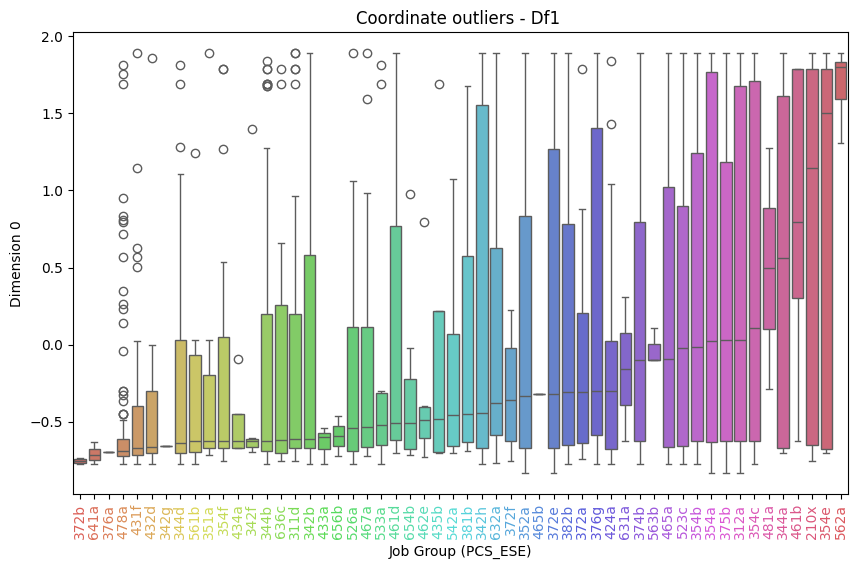

In [9]:
plot_boxplot(dfs[6], 'PCS_ESE', value_col='0', df_number = 1)

In [10]:
# Create a dictionary from 'PCS_ESE' to 'PCS_ESE_name'
pcs_ese_to_name = df1.set_index('PCS_ESE')['PCS_ESE_name'].to_dict()

# Function to get the name for a given code
def get_name_for_code(code):
    return pcs_ese_to_name.get(code, "Code not found")

# Test the function
code = '372f'
print(f"The name for code {code} is {get_name_for_code(code)}")

The name for code 372f is Cadres de la documentation, de l'archivage  (hors fonction publique)


Problematic job groups include:
- 352a Journalistes (y c. rédacteurs en chef) 
- 375b Cadres des relations publiques et de  la communication
- 312a Avocats
- 344b Médecins salariés non hospitaliers
- 372e Juristes


Outliers measured on the basis of coordinates per group. It could seem like especially these job groups are not that consistent, which might bias the estimates later on in the process.

### OLS Assumption checks for non hierarchical multiple Lin Reg

1. Linearity of outcome var and predictor vars
2. Homoscedasticity - Equal variance
3. Normality of error distribution
4. Independent observations, no autocorrelation 
5. Predictors are not correlated with each other
6. Outliers should not be present too far


https://medium.com/@shuv.sdr/multiple-linear-regression-in-python-4ee79d763e8f


Model formula: 

Income ~ dim1 + dim2 + dim3, data = [m1...m9]

#### 1 Linearity of independent and dependent variables - Not really

As the value of the X increases, the value of y should also increase or decrease linearly. If there are multiple independent features, each of the independent features should have a linear relationship with the dependent feature.

I find that none of the predictors, regardless of the data frame (model) used, displays a very clear linear relationship. This is partly because of the large degree of variation within estimates for groups. However, there might be some linear tendencies, especially in the grouped data (median estimates per group), suggesting we could use regression to do the model comparison.

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


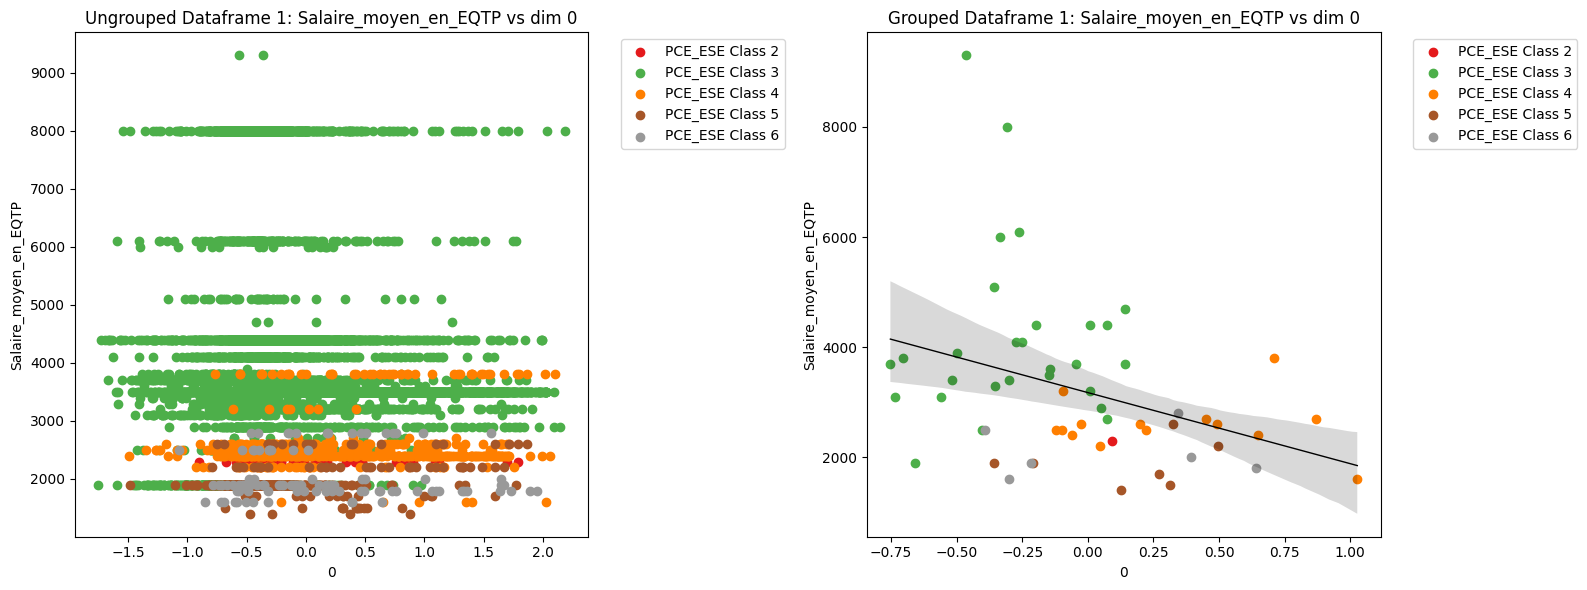

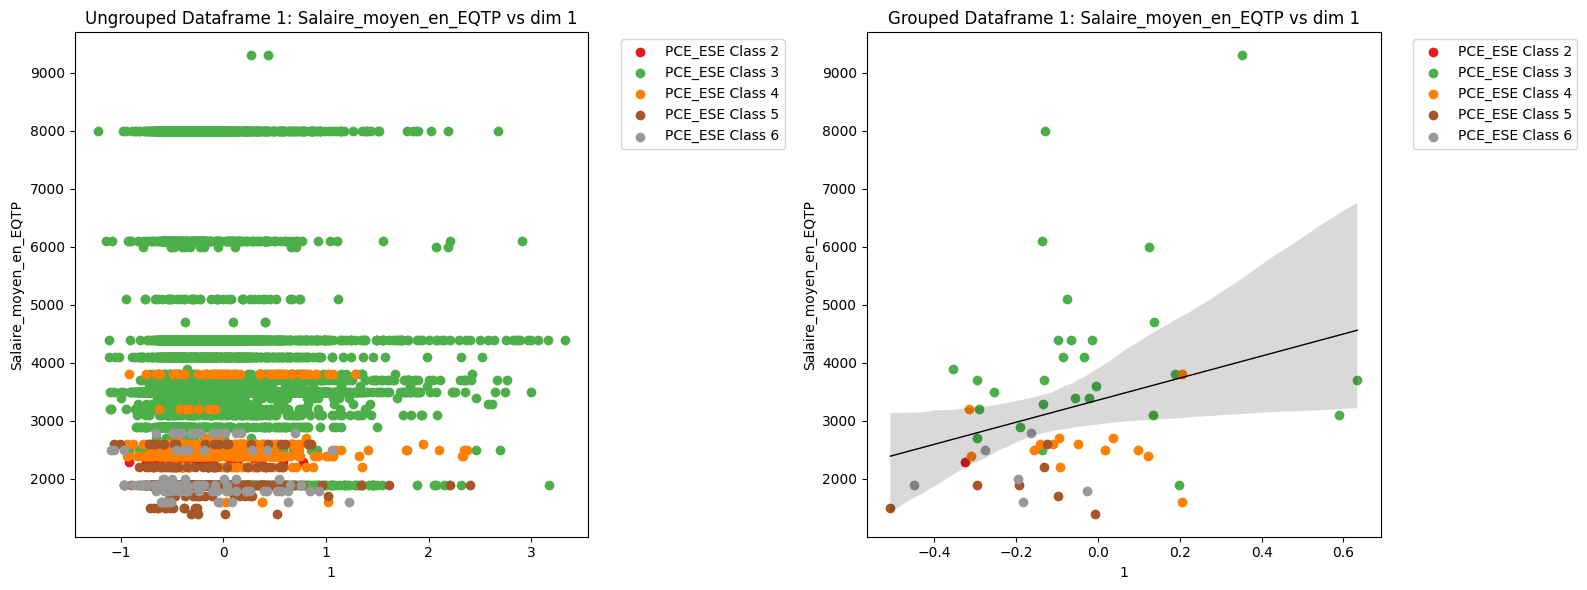

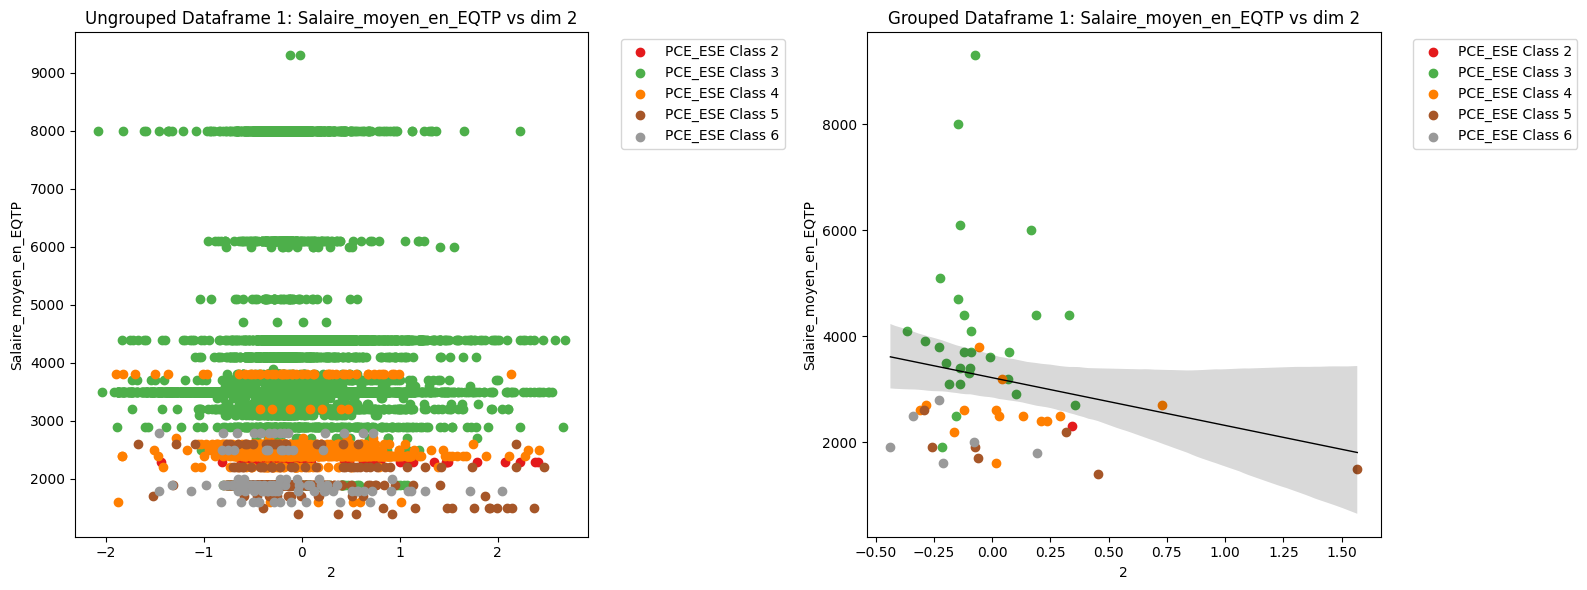

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


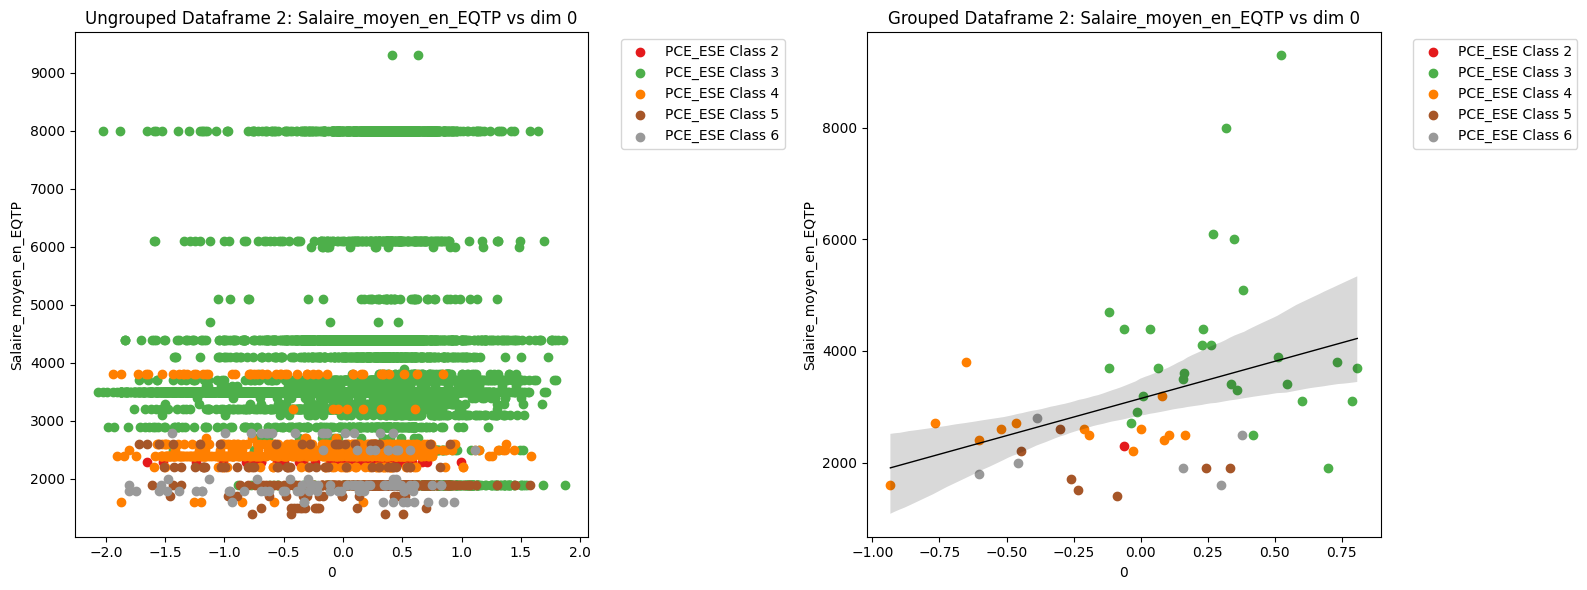

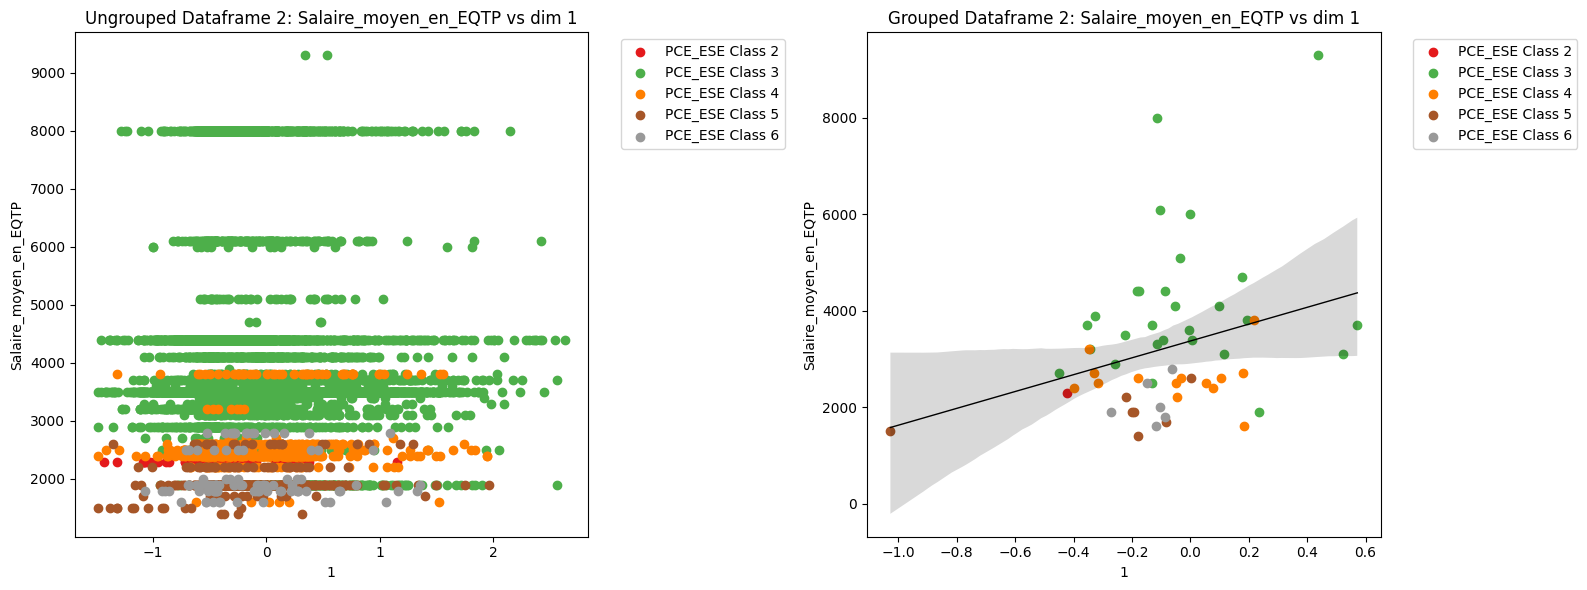

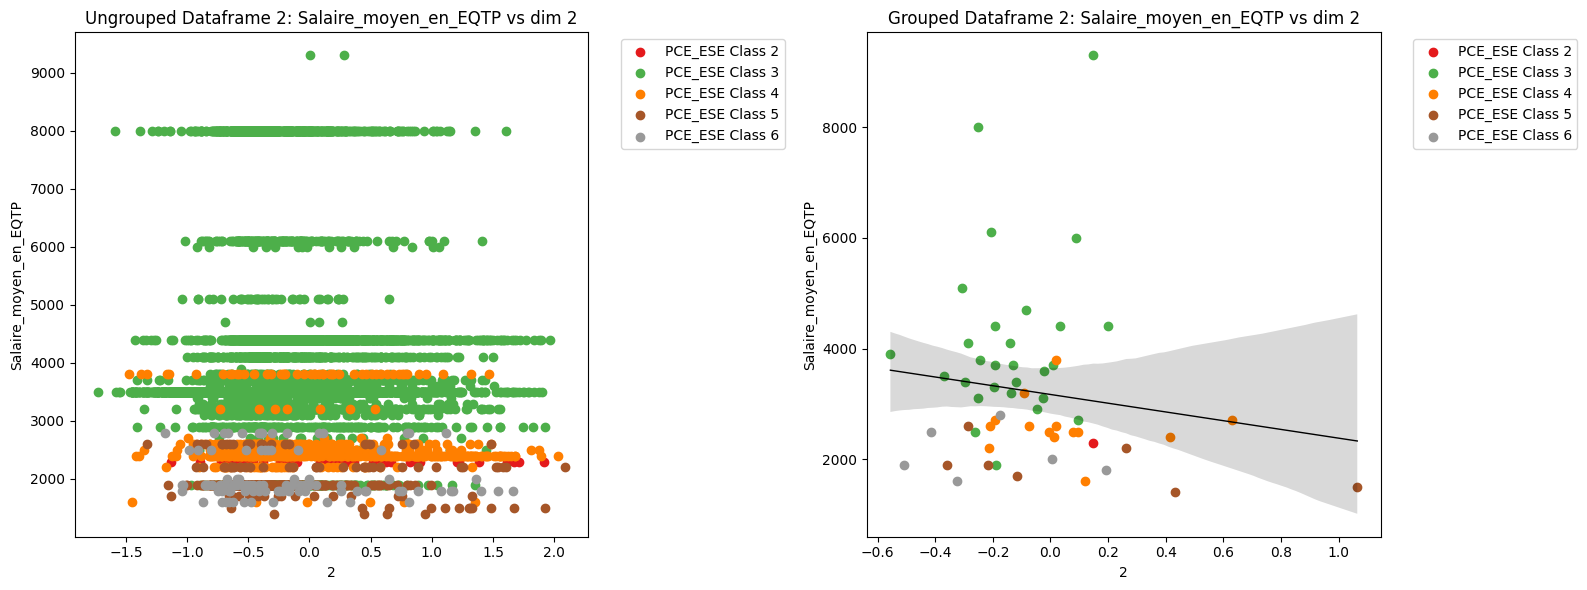

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


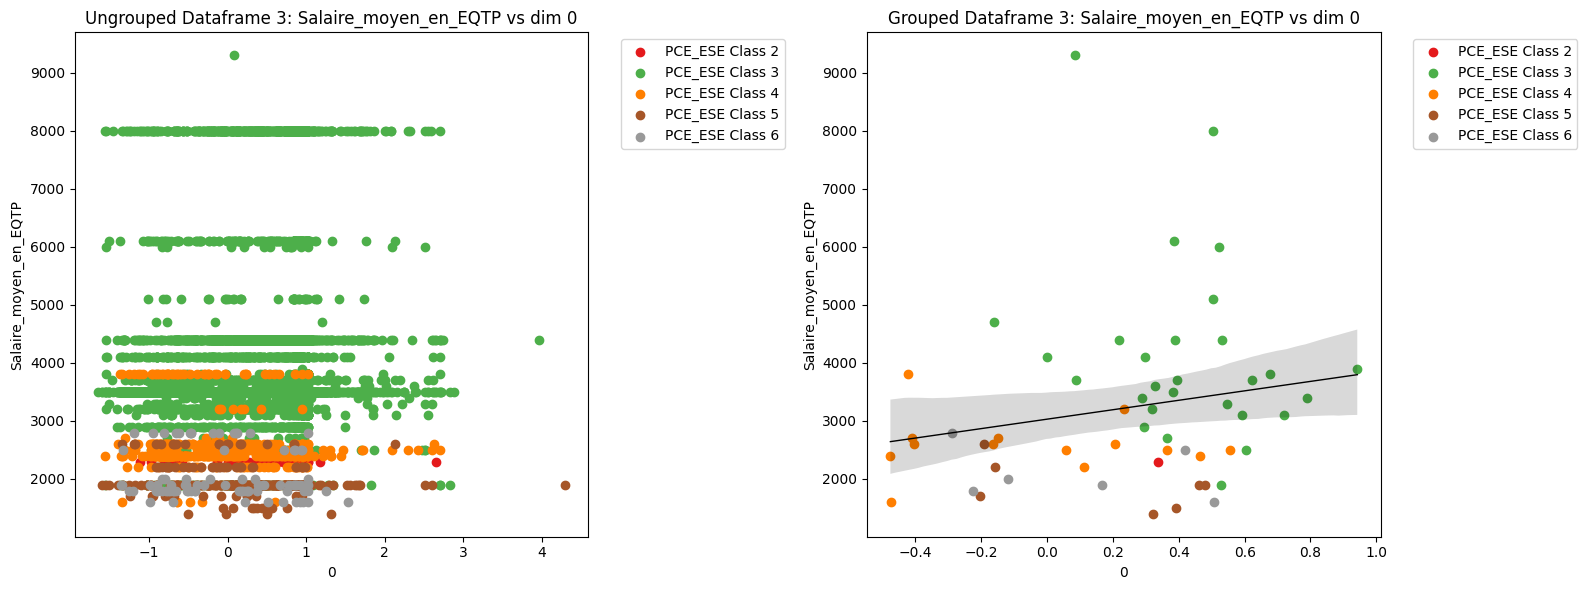

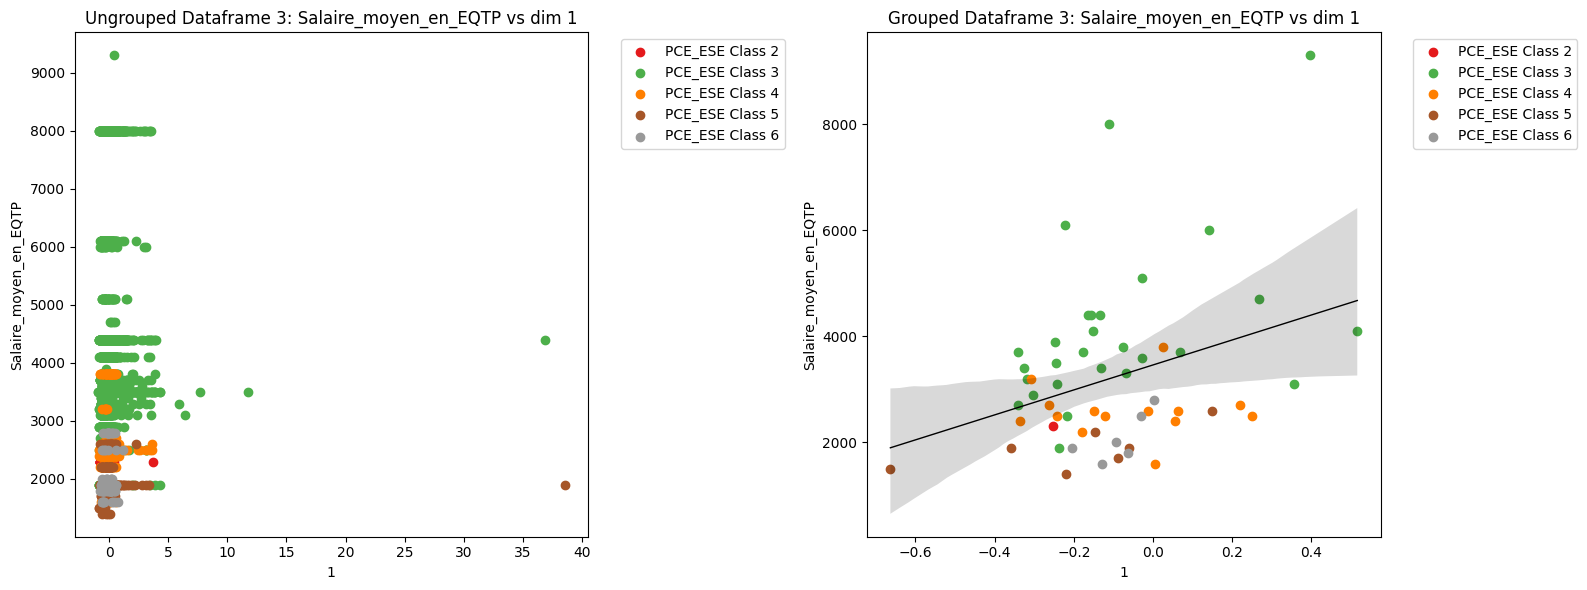

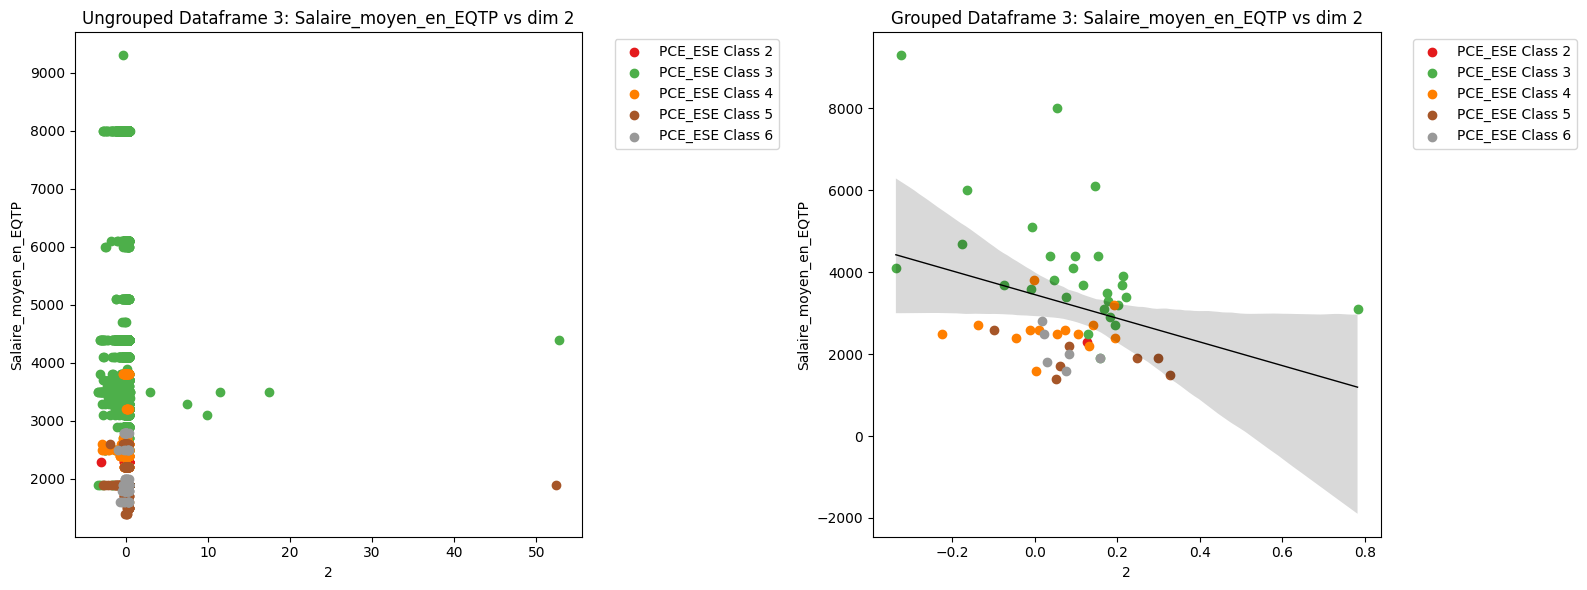

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


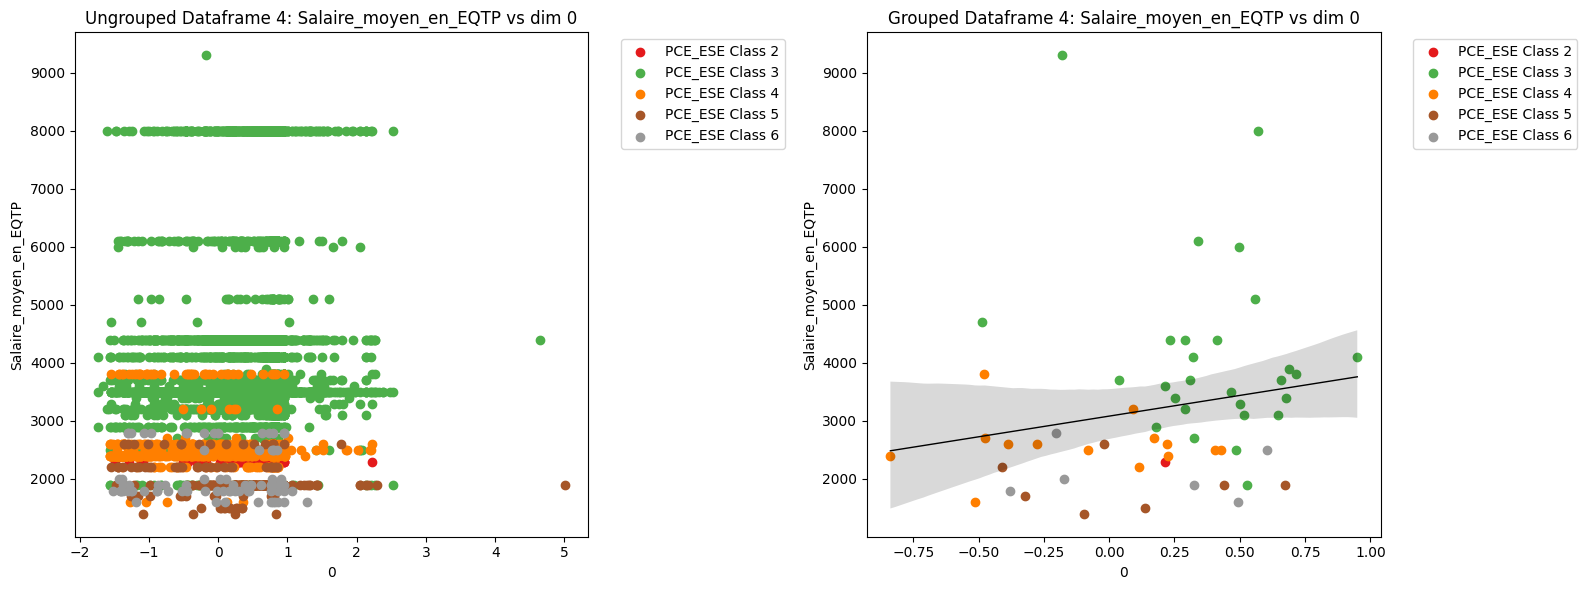

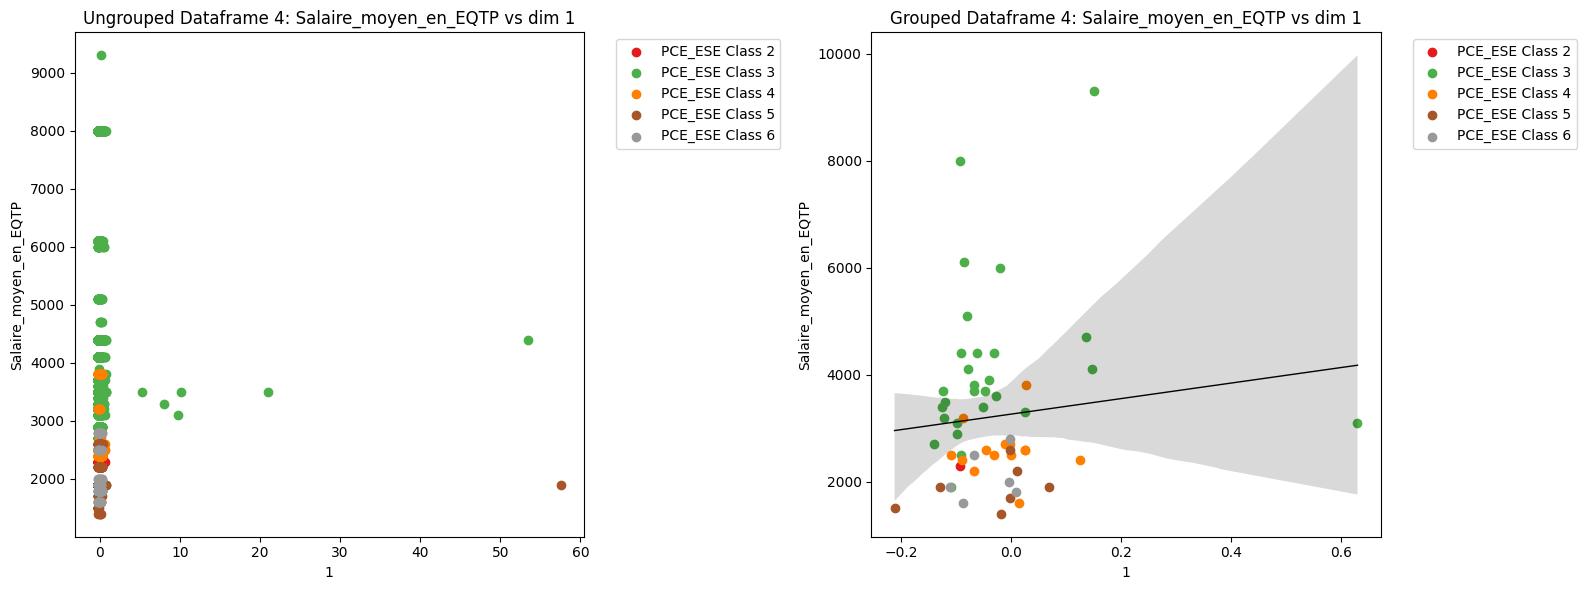

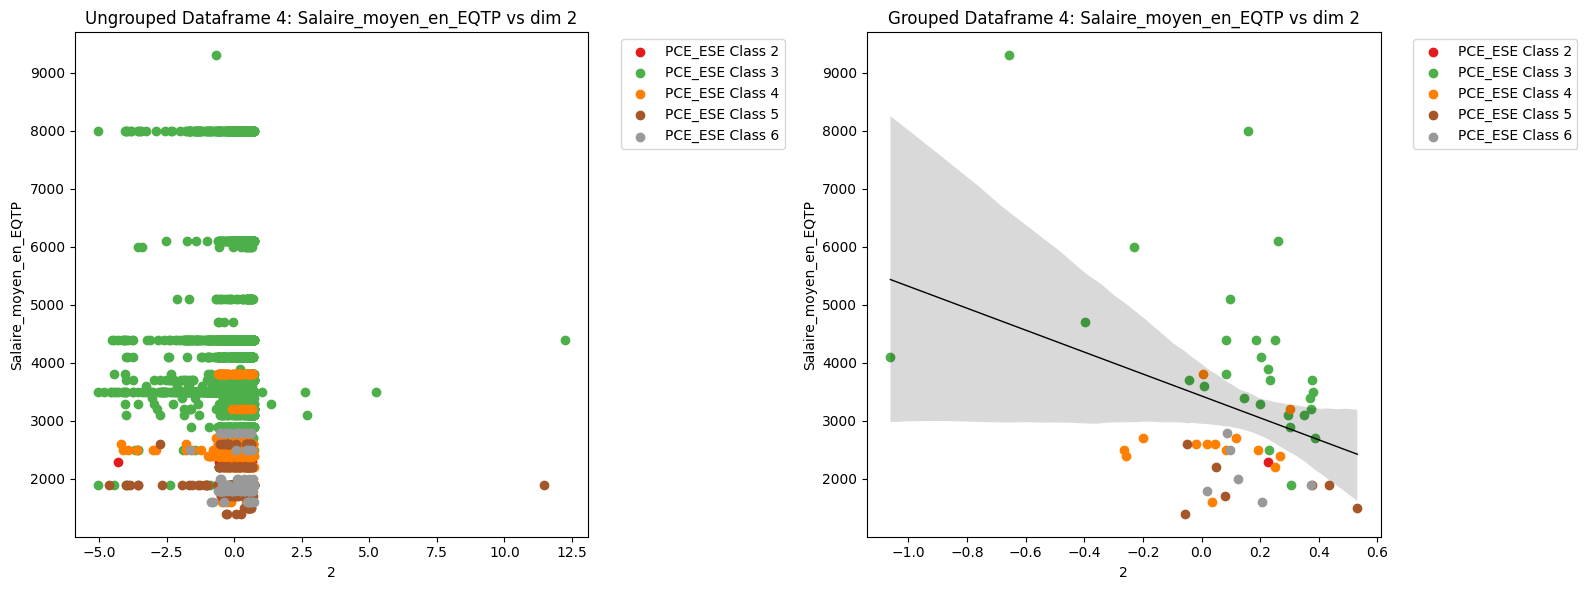

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


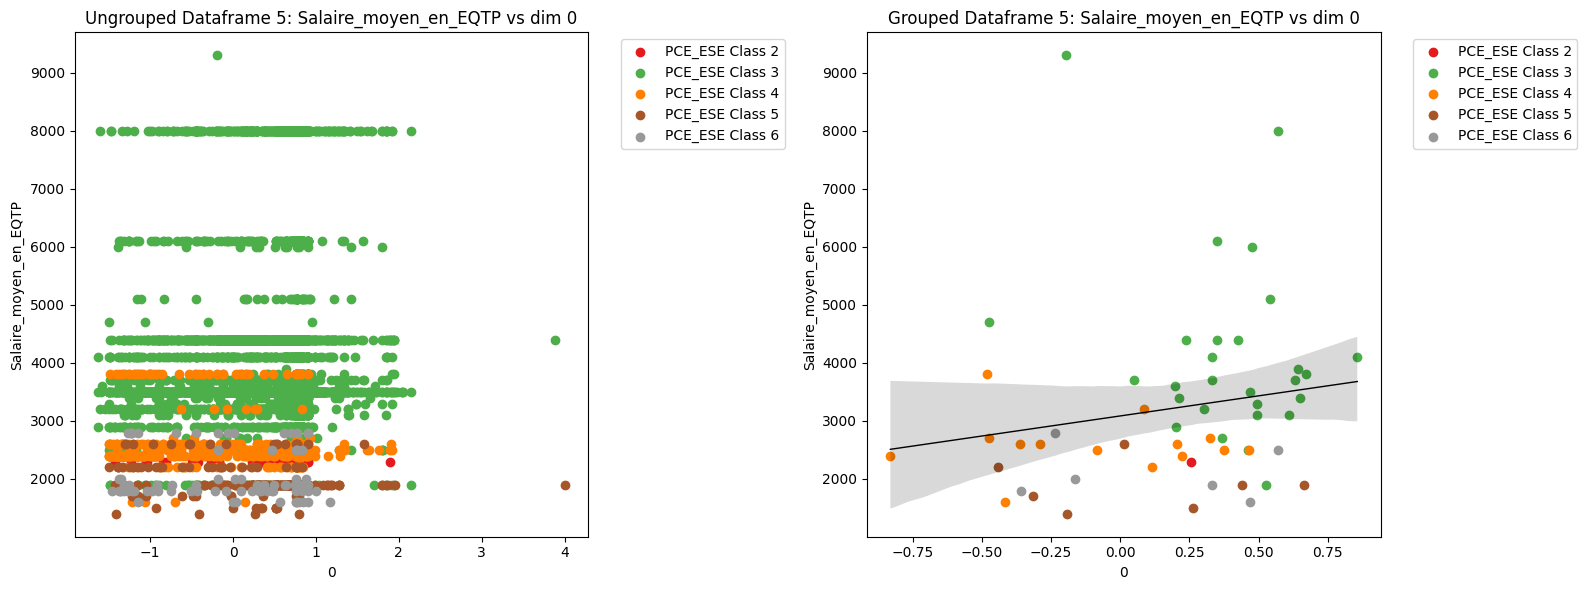

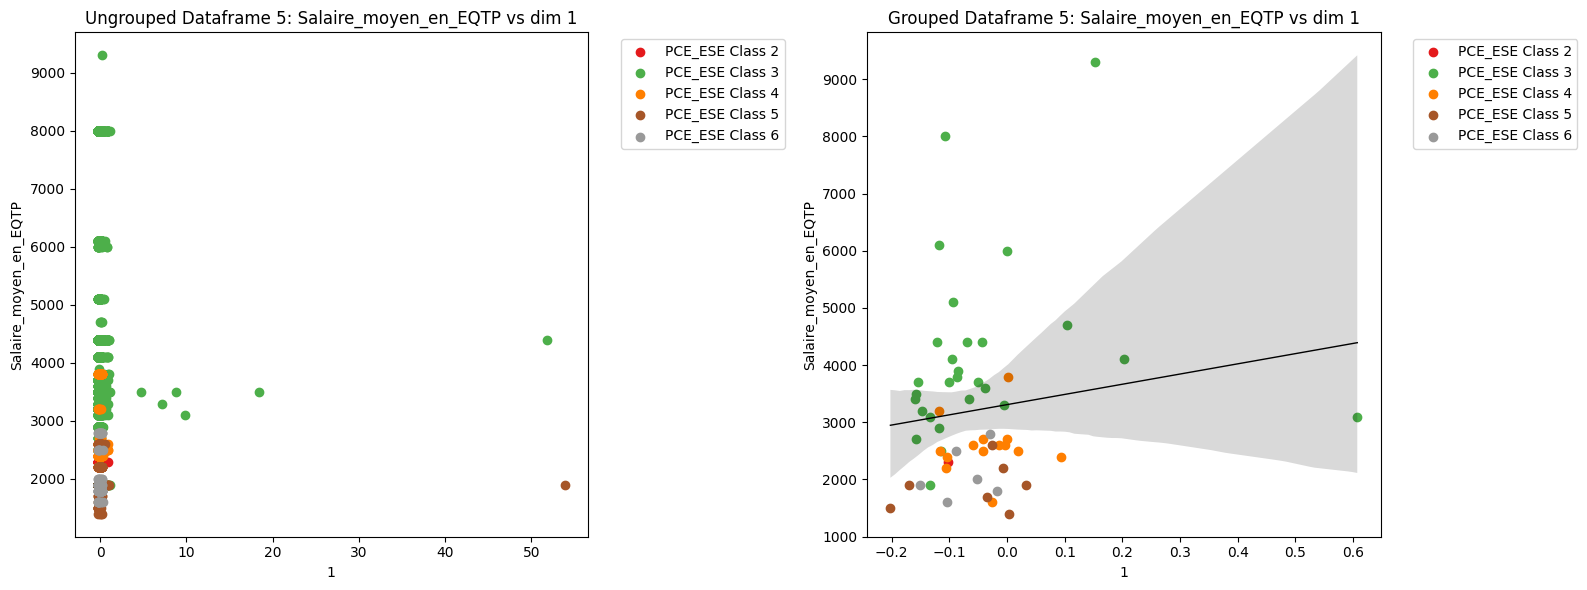

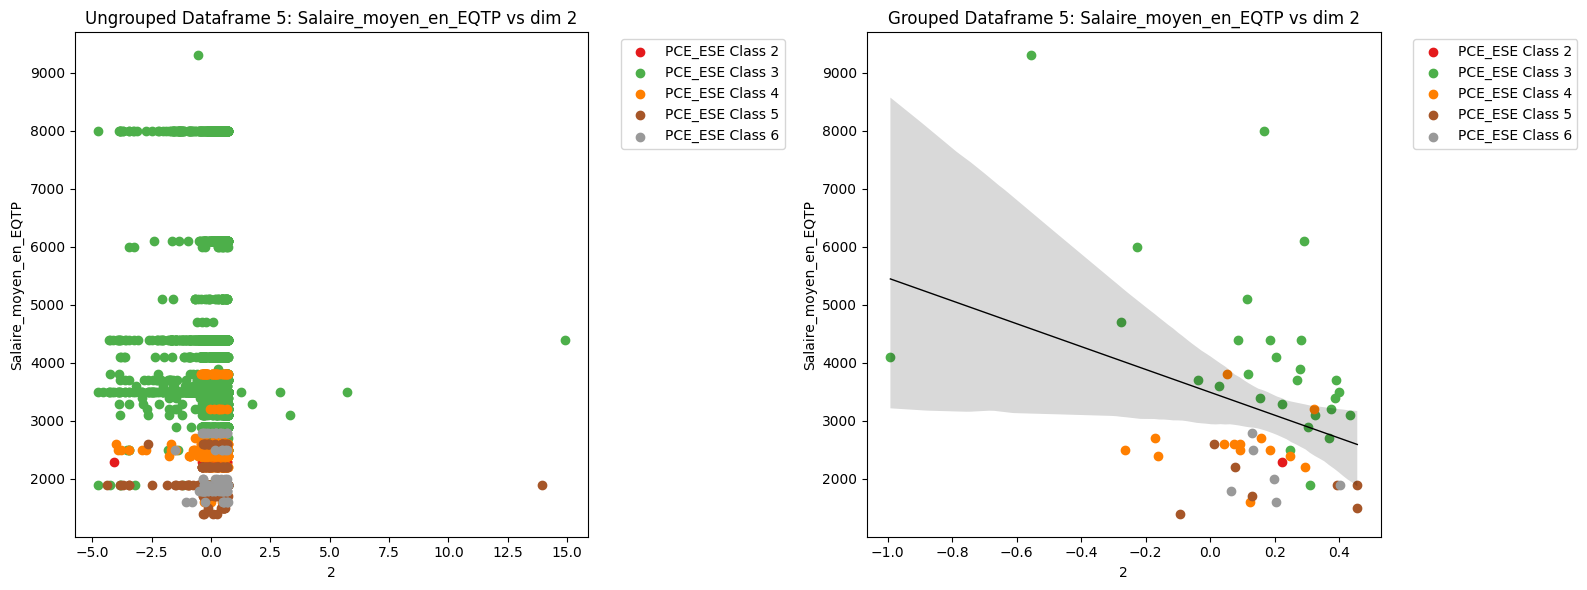

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


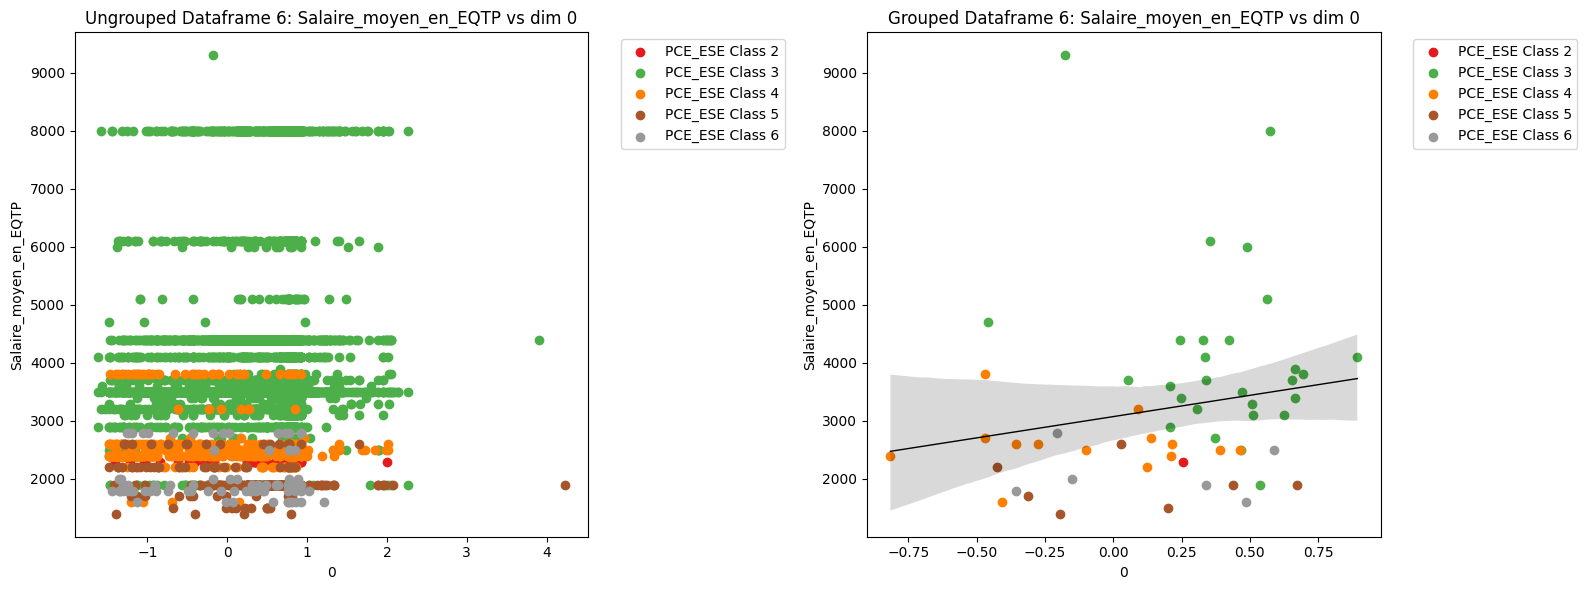

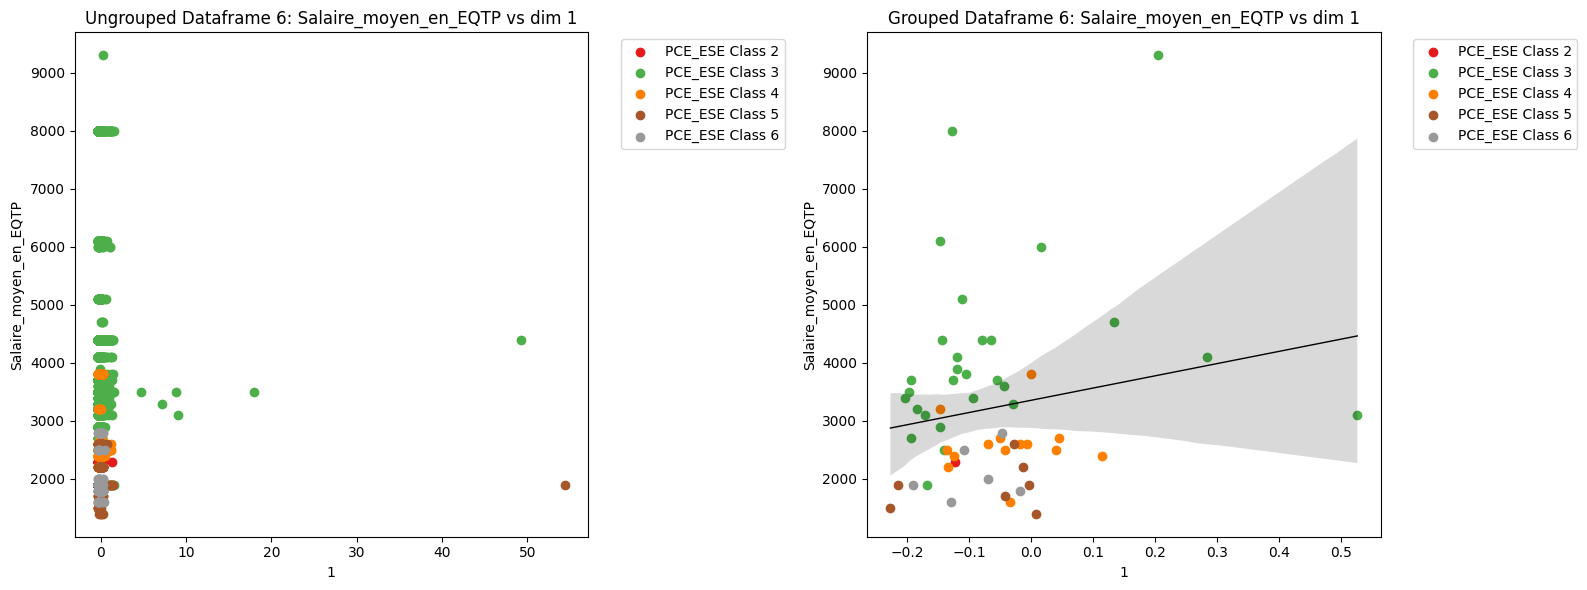

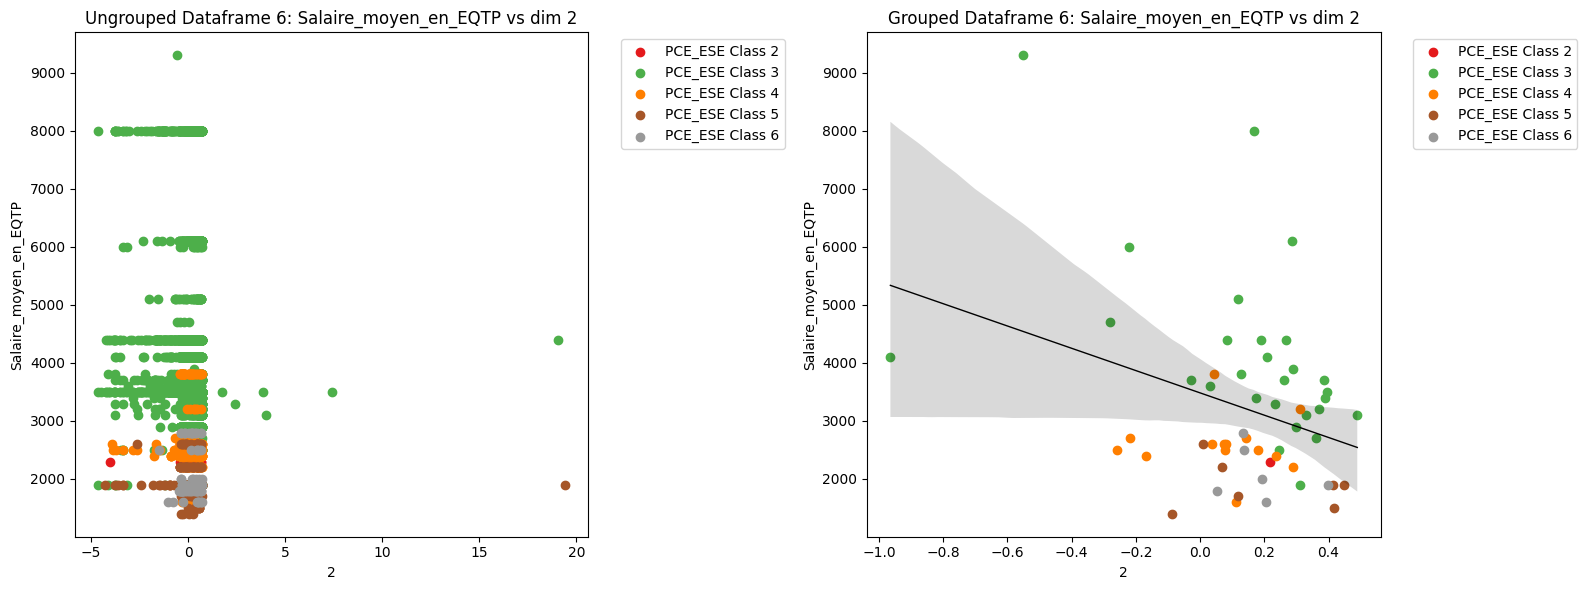

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


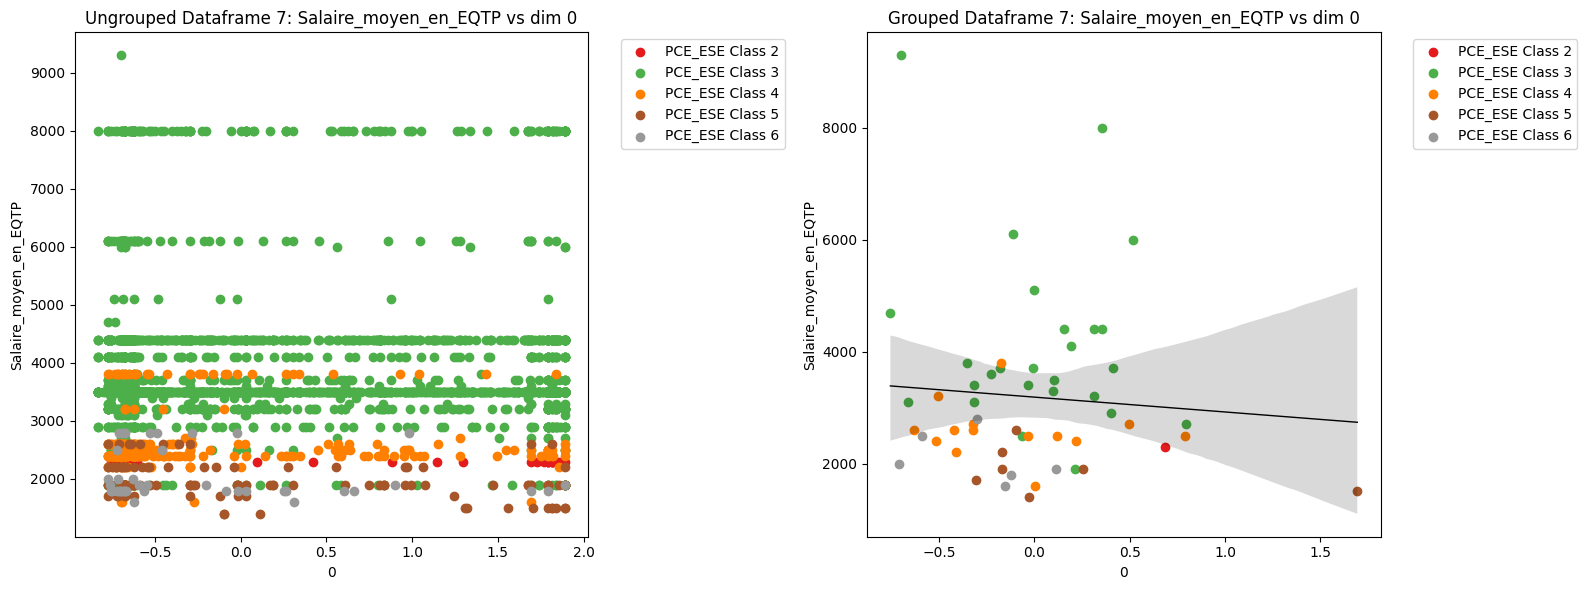

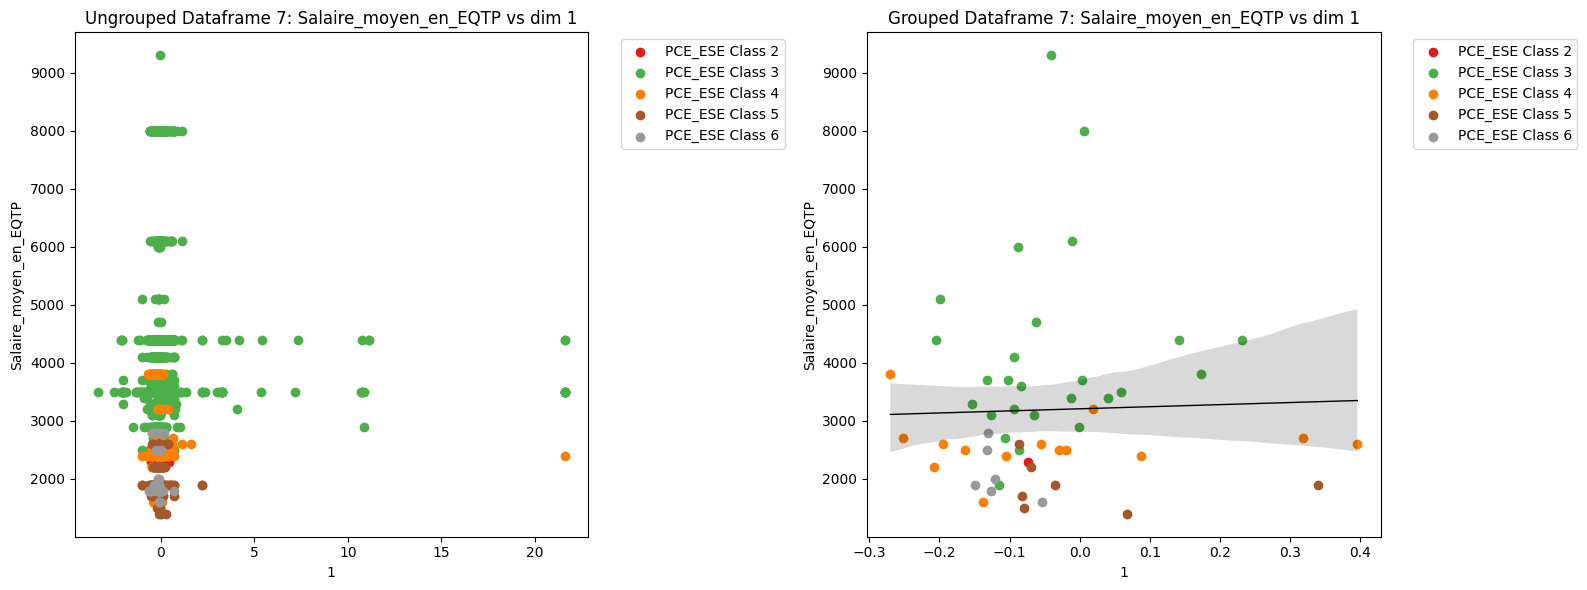

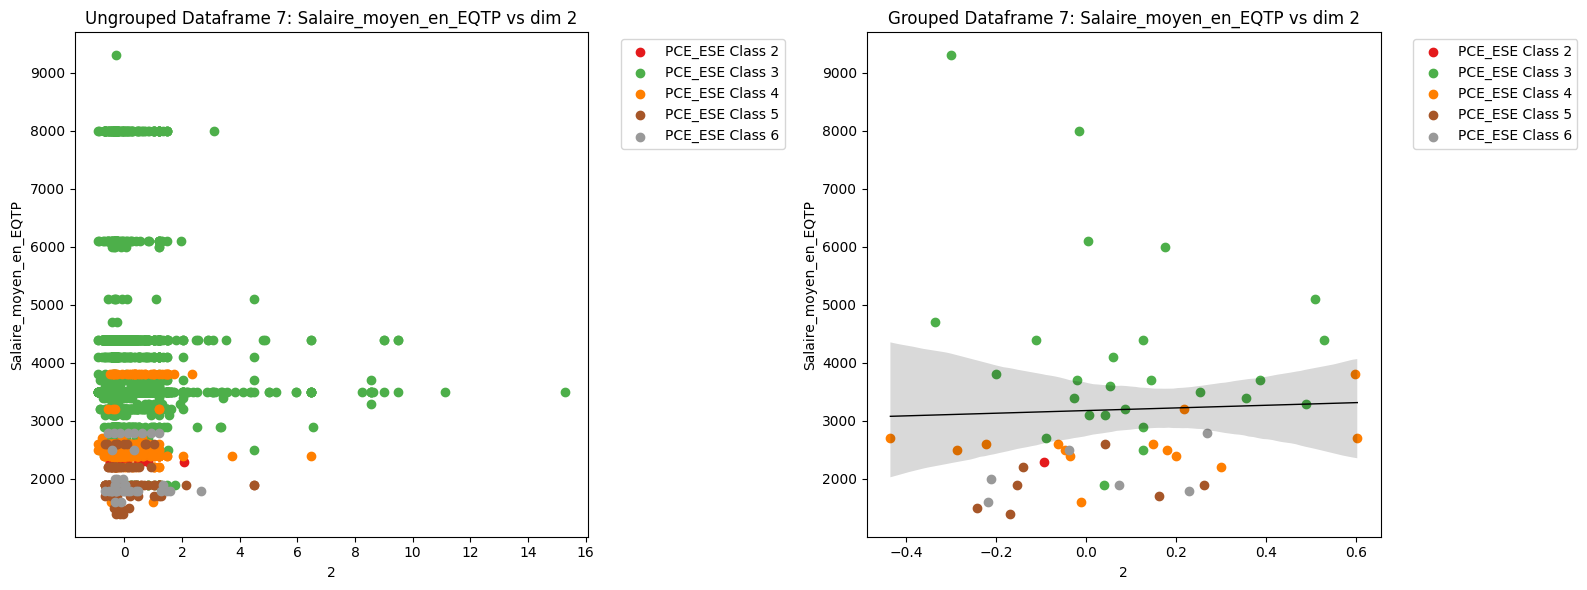

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


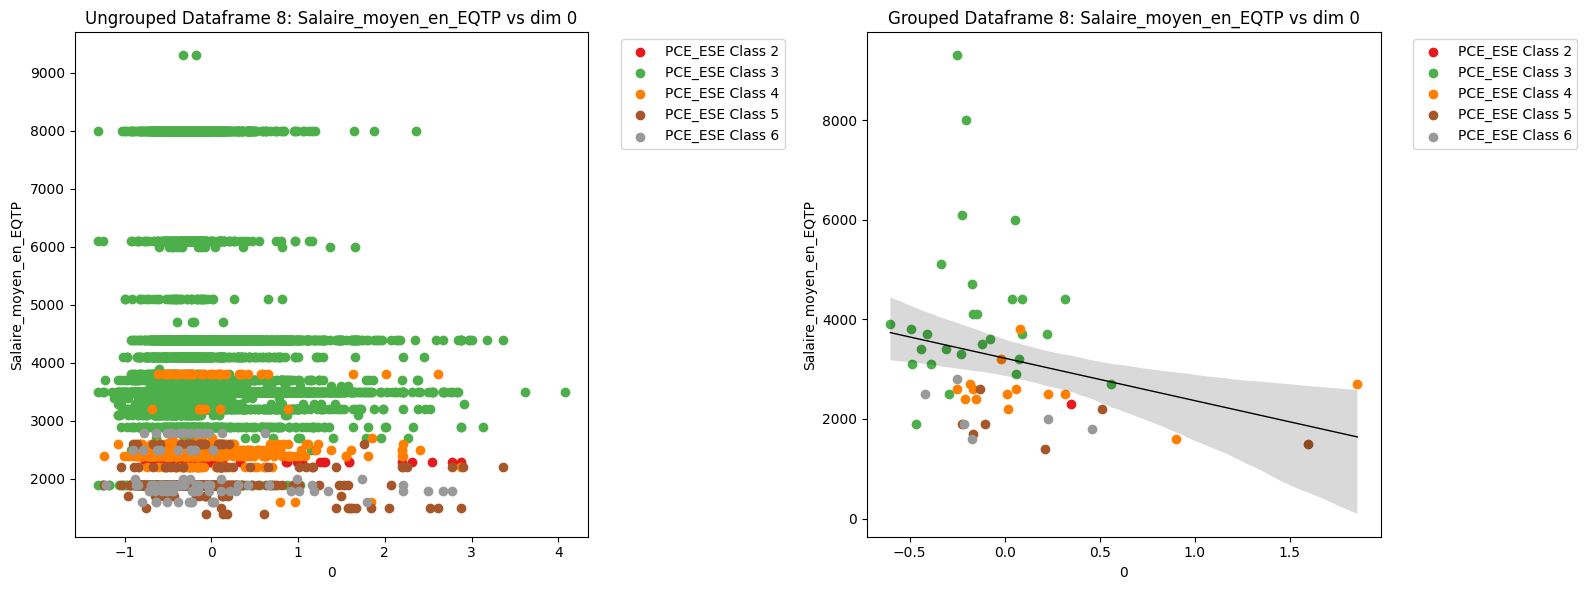

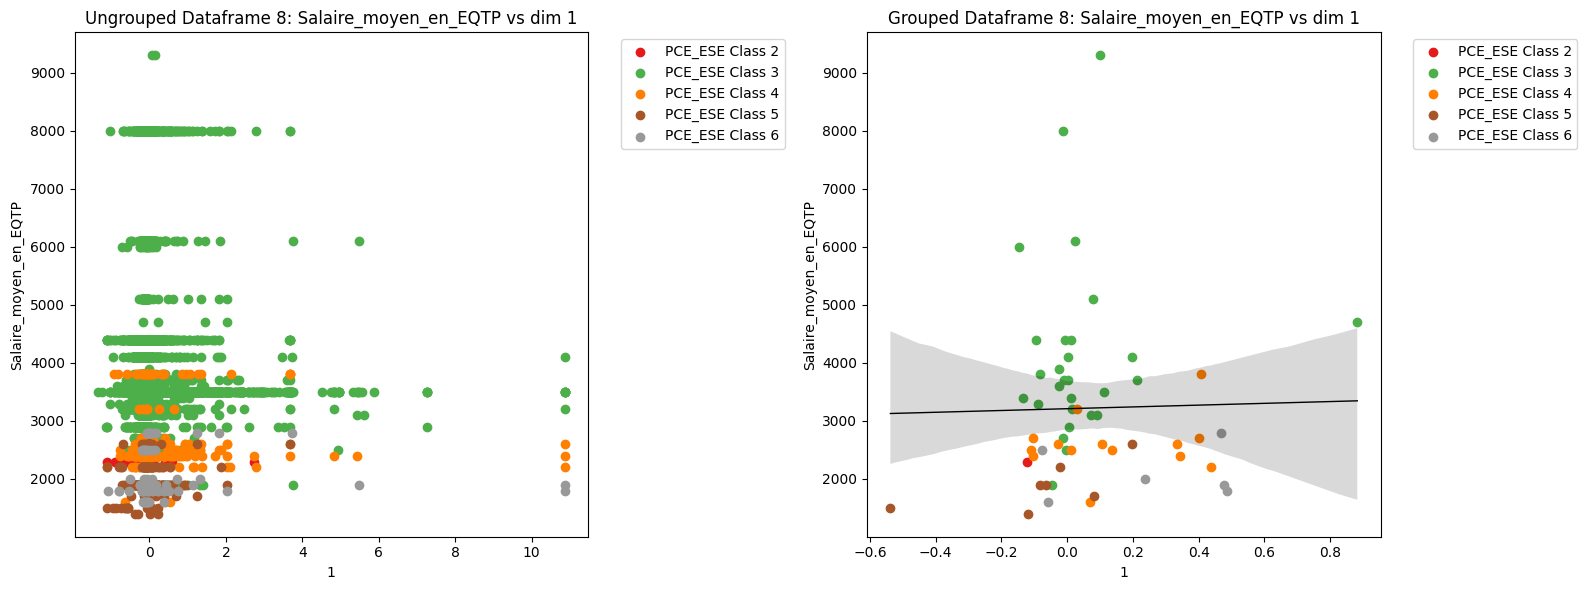

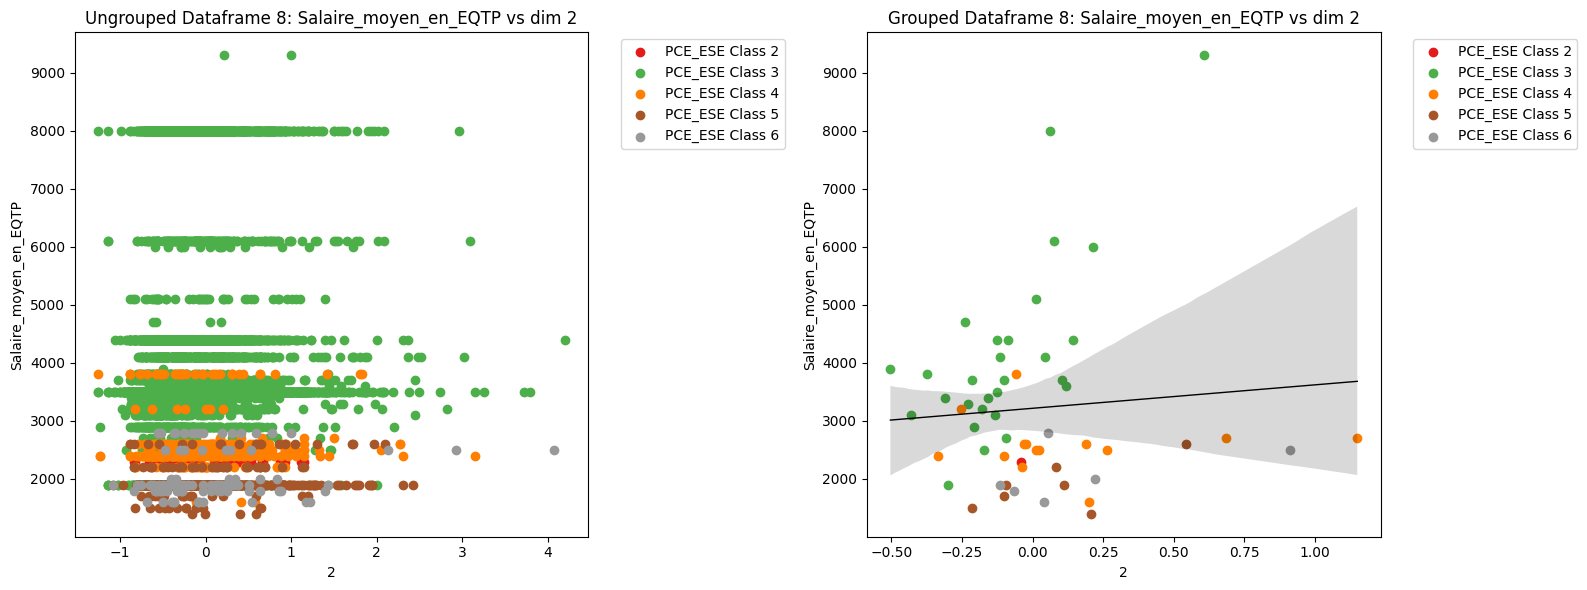

/tmp/ipykernel_2979850/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


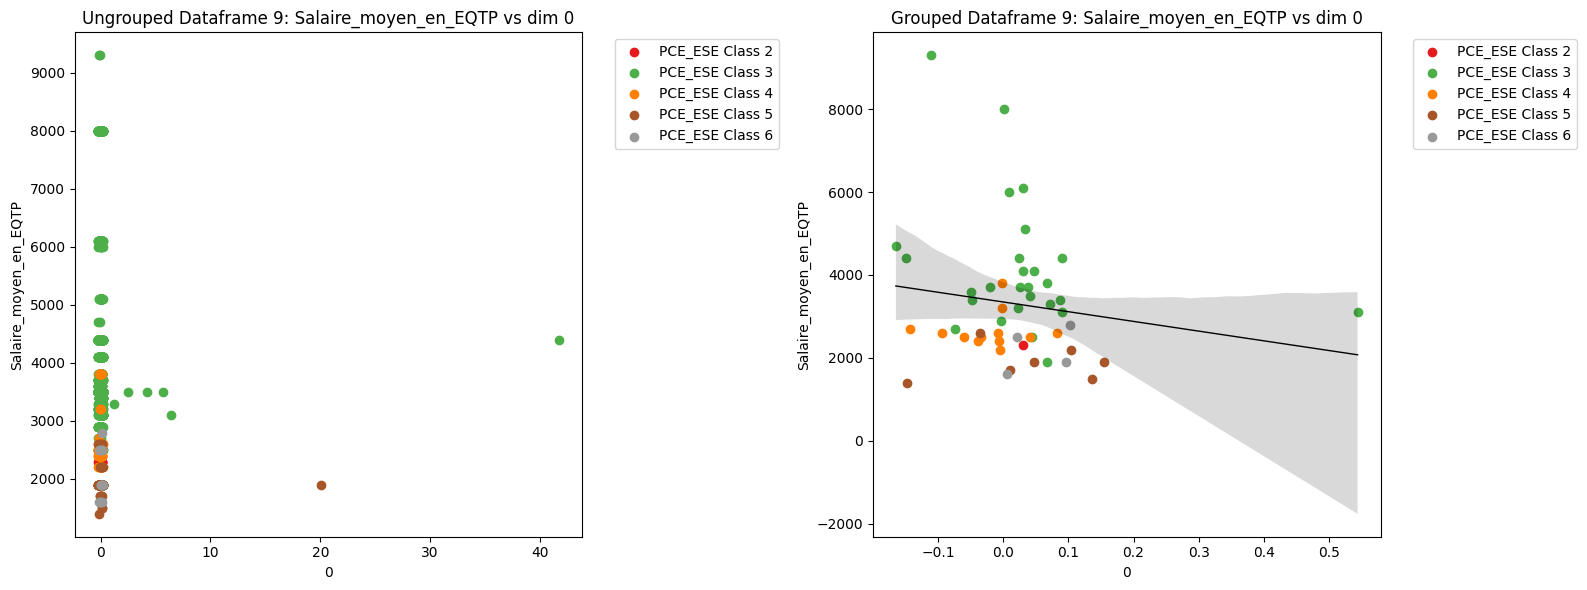

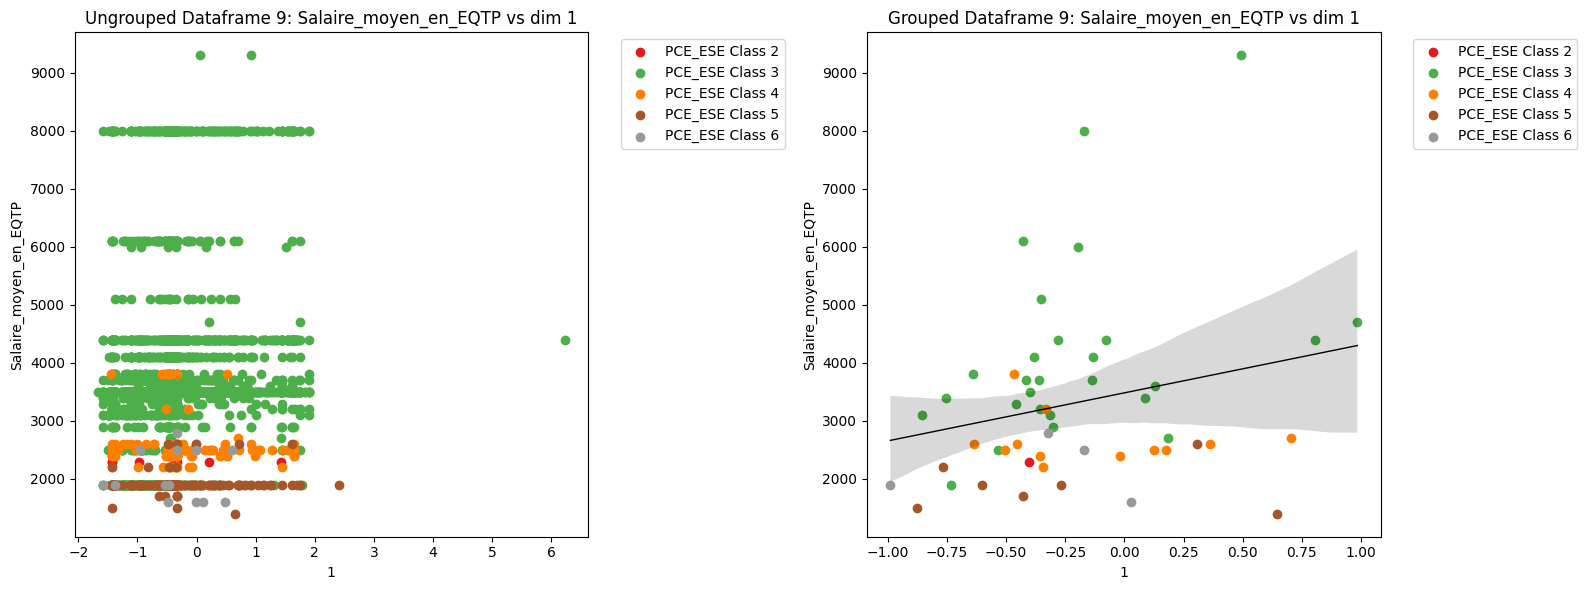

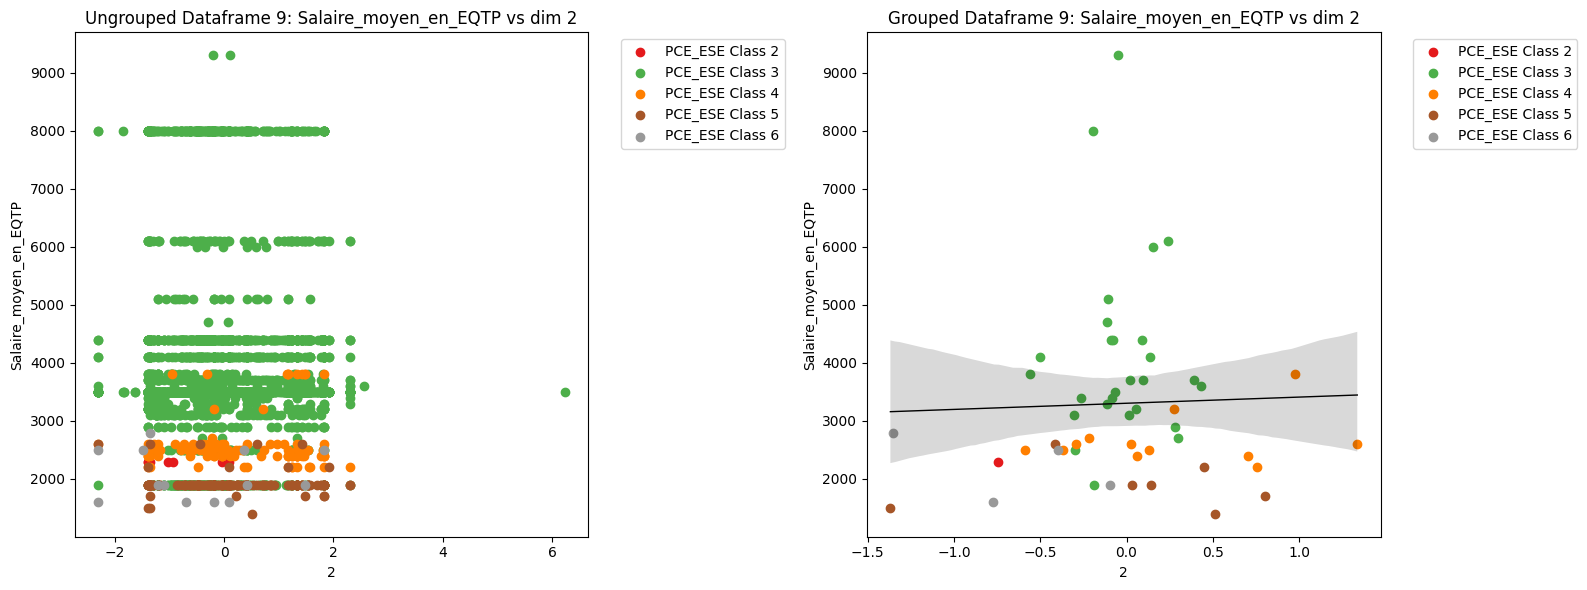

In [4]:
import seaborn as sns

## Not log transformed
outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs]))

# Plot scatter plots for each dataframe
for i, df in enumerate(dfs):
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    for predictor in predictors:
        plt.figure(figsize=(16, 6))
        
        # Ungrouped data
        plt.subplot(1, 2, 1)
        for color in color_categories:
            plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome], 
                        c=color_map[color], label=f'PCE_ESE Class {color}')
        plt.xlabel(predictor)
        plt.ylabel(outcome)
        plt.title(f'Ungrouped Dataframe {i+1}: {outcome} vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Grouped data
        plt.subplot(1, 2, 2)
        for color in color_categories:
            plt.scatter(grouped_df.loc[grouped_df['color'] == color, predictor], 
                        grouped_df.loc[grouped_df['color'] == color, outcome], 
                        color=color_map[color], label=f'PCE_ESE Class {color}')
        sns.regplot(x=grouped_df[predictor], y=grouped_df[outcome], 
                    color='black', scatter=False, ci=95, line_kws={'linewidth': '1'})
        plt.xlabel(predictor)
        plt.ylabel(outcome)
        plt.title(f'Grouped Dataframe {i+1}: {outcome} vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

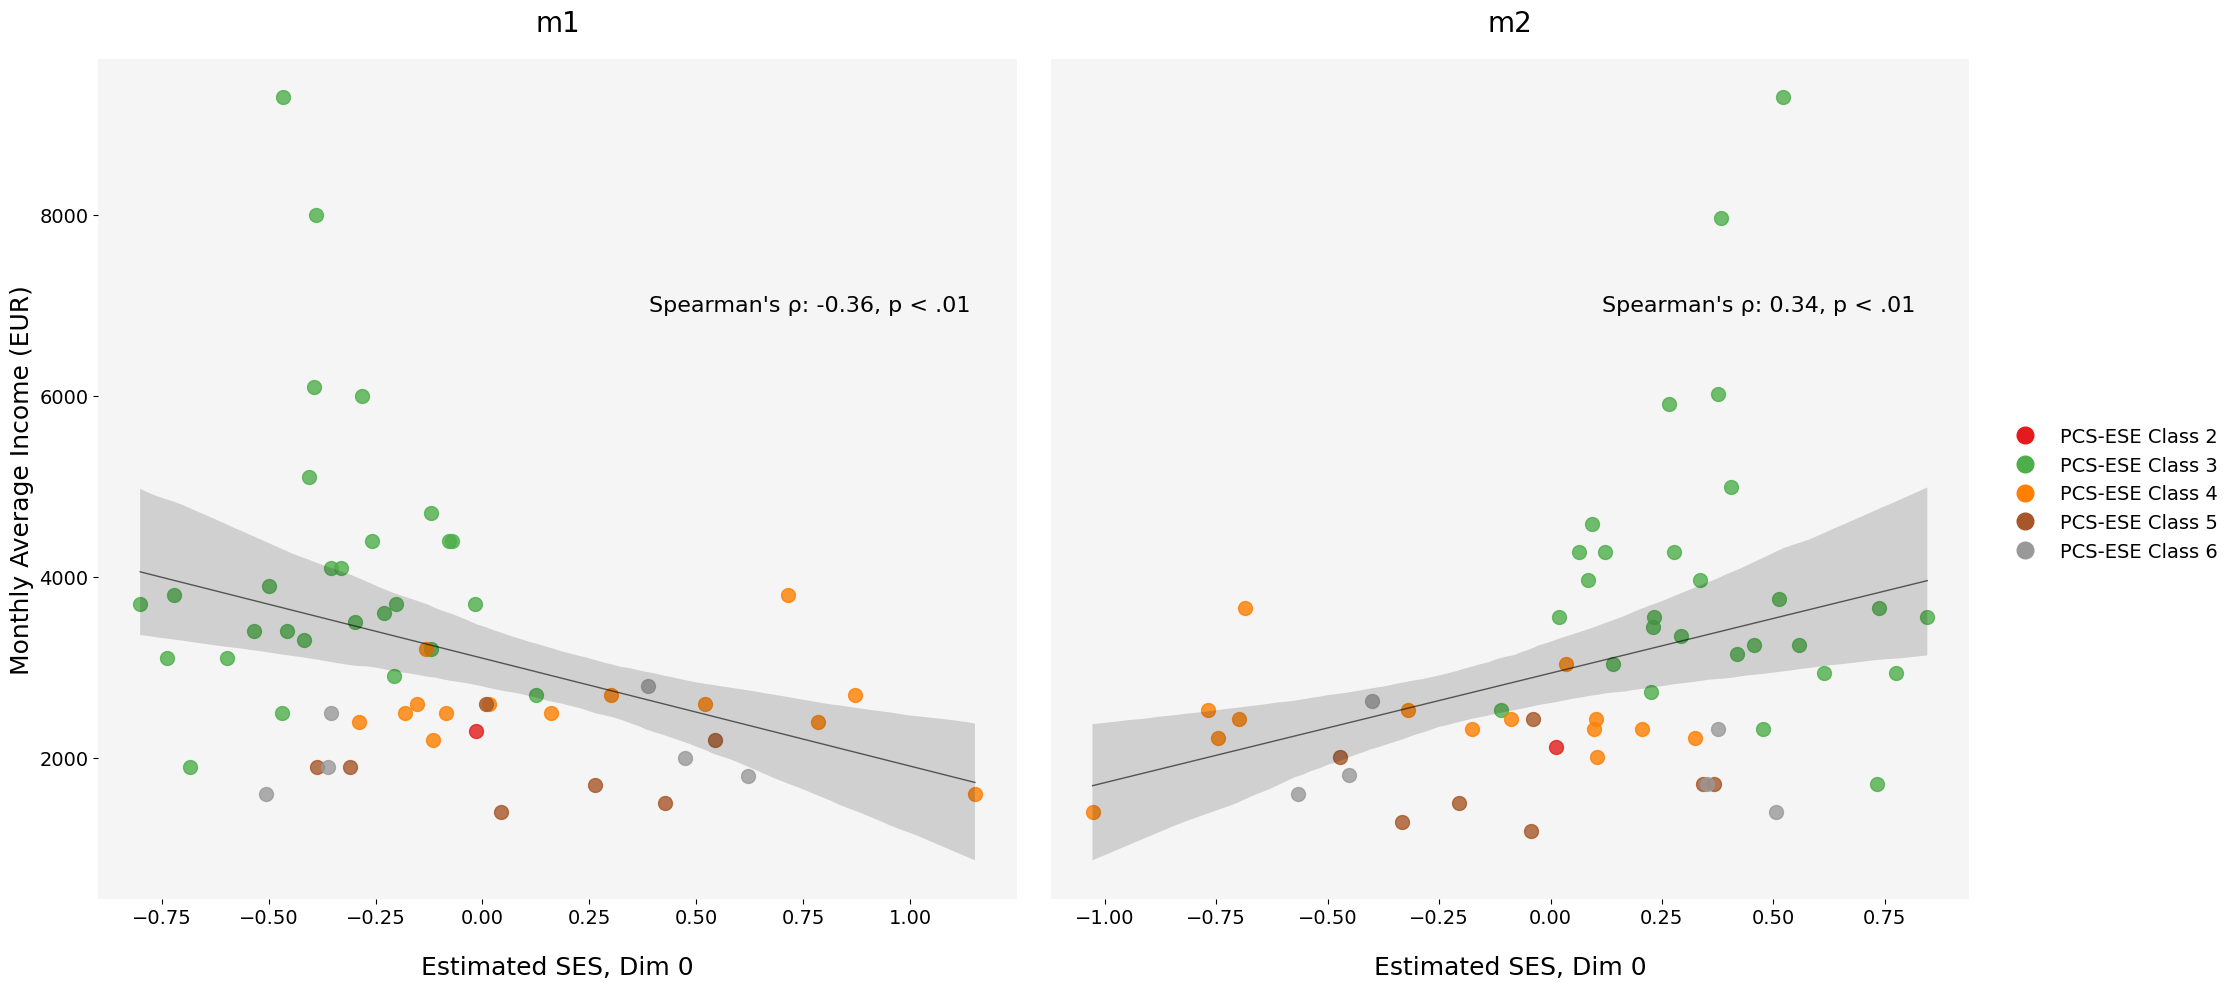

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

outcome = 'Salaire_moyen_en_EQTP'
predictor = '0'  # Only use dimension '0'

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs[:2]]))  # Only first two dfs

# Create a grid of plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of subplots
plt.subplots_adjust(wspace=0.05)  # Adjust space between subplots

axes = axes.flatten()  # Flatten the axes array to loop over it

for i, df in enumerate(dfs[:2]):  # Only first two dfs
    df = df.copy()
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[[predictor, outcome]].median()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    ax = axes[i]  # Corrected indexing here
    ax.set_facecolor('whitesmoke')  # Set slight background shading color

    # Calculate correlation and adjust alpha based on it
    corr, _ = spearmanr(grouped_df[predictor], grouped_df[outcome])  # Use Spearman's correlation
    
    # Grouped data
    for color in color_categories:
        ax.scatter(grouped_df.loc[grouped_df['color'] == color, predictor], 
                   grouped_df.loc[grouped_df['color'] == color, outcome], 
                   color=color_map[color], alpha=0.8, s=100, label=f'PCE-ESE Class {color}')
    sns.regplot(x=grouped_df[predictor], y=grouped_df[outcome], 
                color='black', scatter=False, ci=95, line_kws={'linewidth': '1', 'alpha': 0.6}, ax=ax)
    if i == 0:  # Only set y label for left subplot
        ax.set_ylabel('Monthly Average Income (EUR)', fontsize=18)
    else:
        ax.set_ylabel('')  # Remove y label for other subplots
        ax.set_yticks([])
        
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Estimated SES, Dim 0', fontsize=18, labelpad=20)
    ax.text(0.6, 0.7, f"Spearman's ρ: {corr:.2f}, p < .01", fontsize=16, transform=ax.transAxes)

    # Remove box around subplot
    for position in ['top', 'right', 'bottom', 'left']:
        ax.spines[position].set_visible(False)

    # Add model type as title over each subplot
    ax.set_title(f"m{i+1}", fontsize=20, pad=20)

# Create custom legend handles
legend_handles = [mlines.Line2D([], [], color=color_map[color], marker='o', linestyle='None',
                                 markersize=12, label=f'PCS-ESE Class {color}') for color in color_categories]
fig.legend(handles=legend_handles, bbox_to_anchor=(1.12, 0.5), loc='center right', fontsize=14, frameon=False)  # Legend to the middle right

plt.tight_layout()
plt.show()

Predicted vs observed outcome

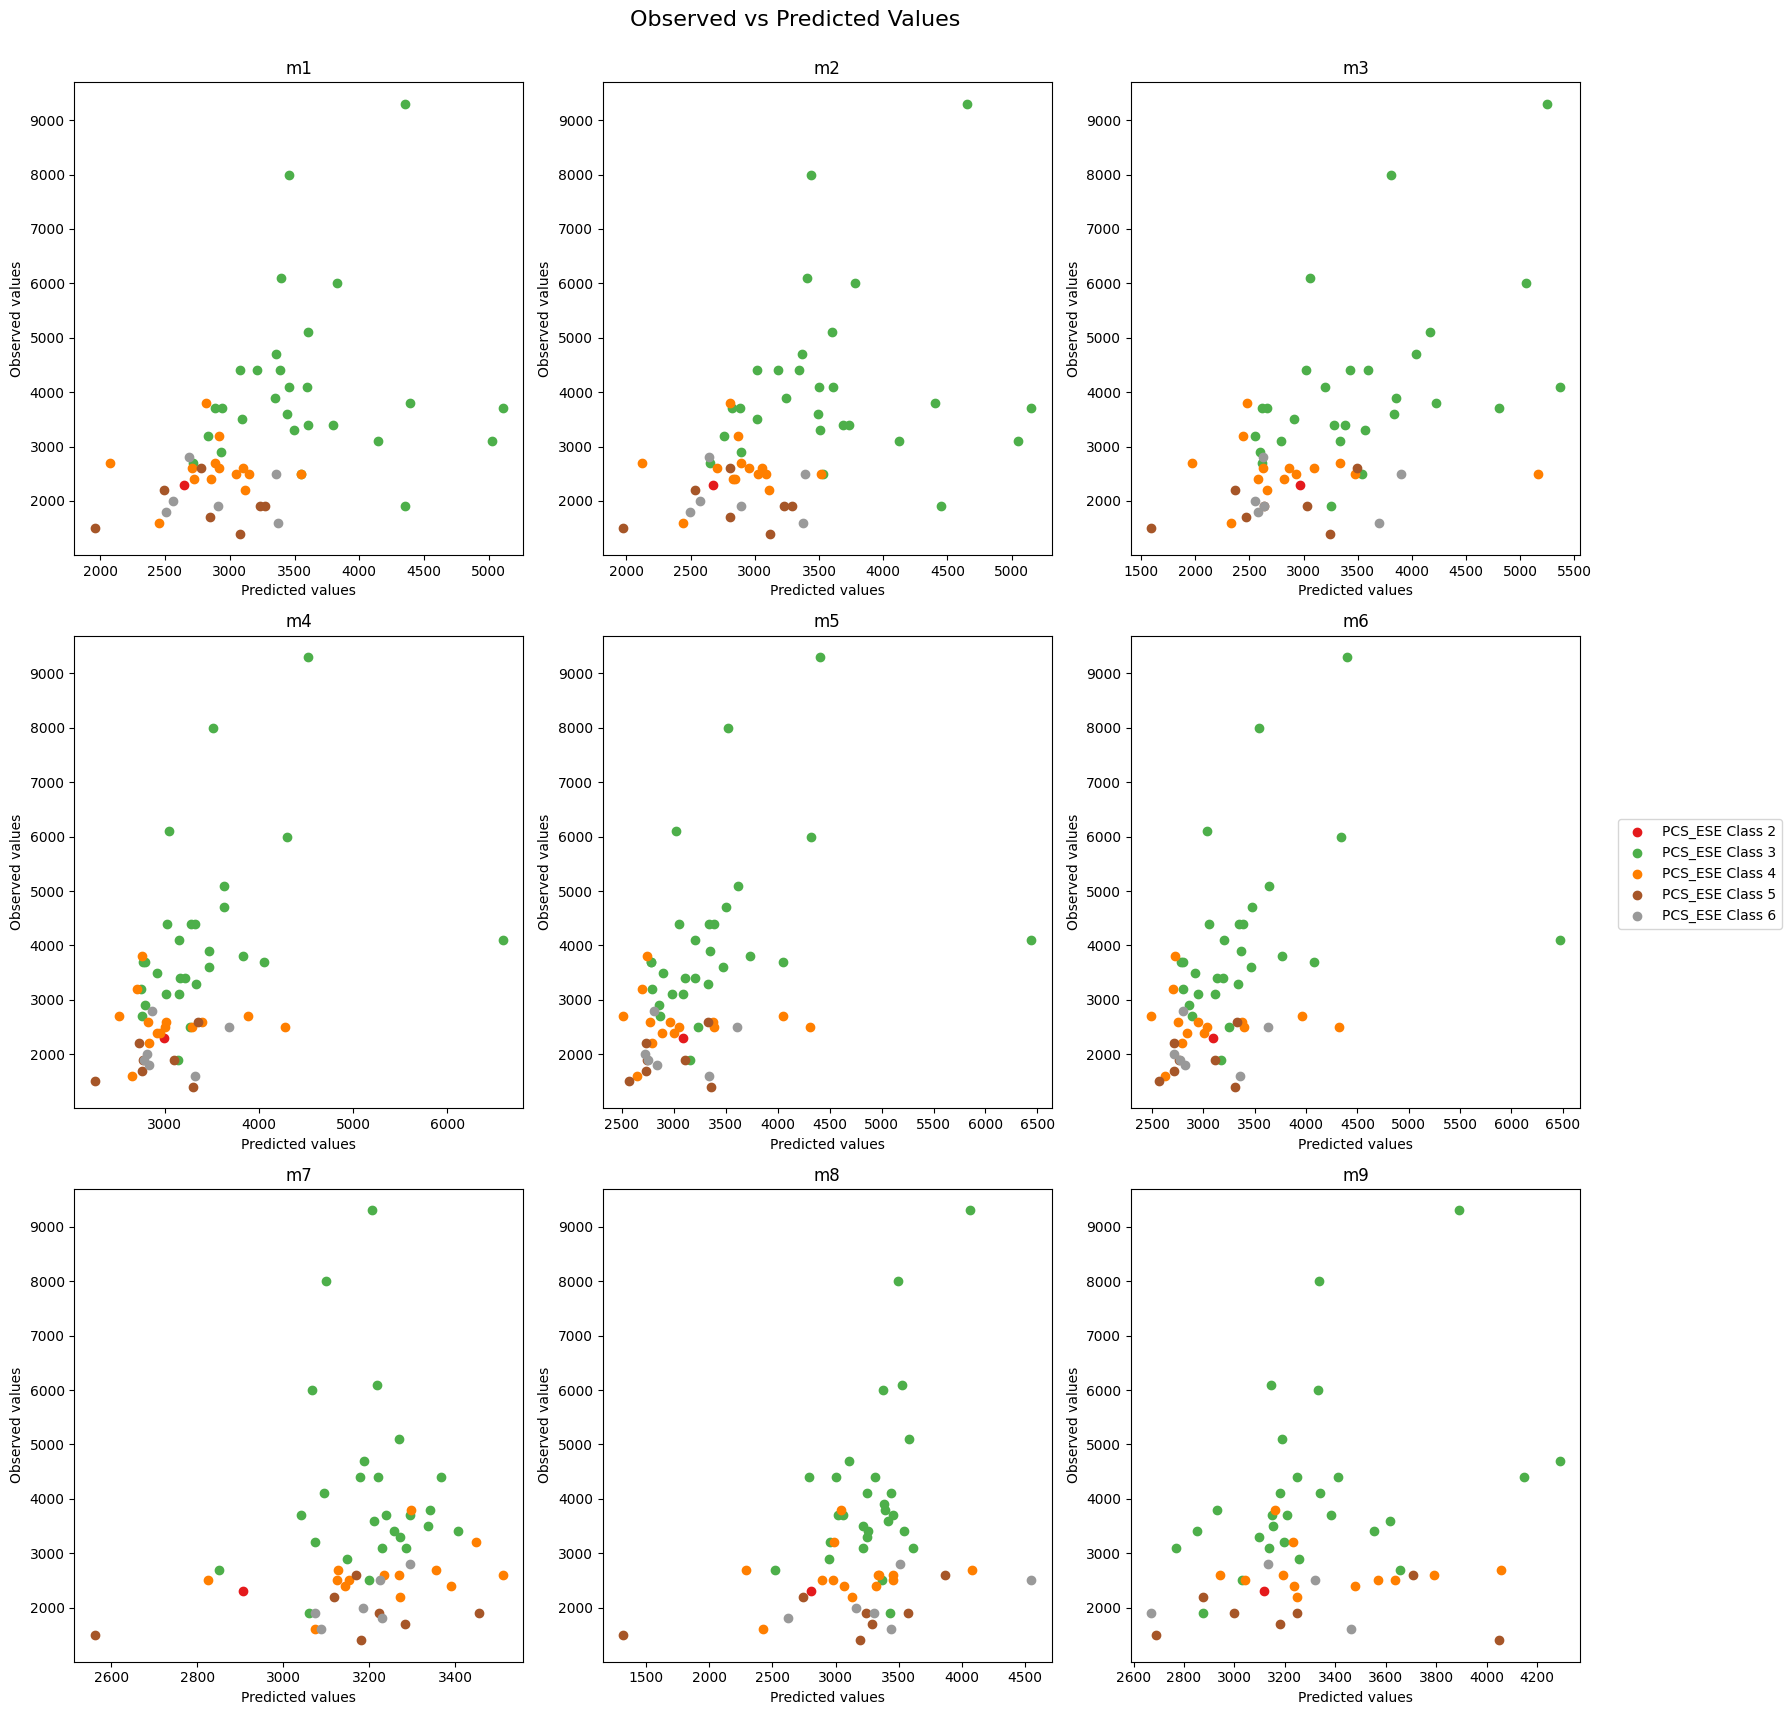

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs]))

# Create a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(16, 18))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Placeholder for legend handles
handles, labels = [], []

for i, df in enumerate(dfs):
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    # Fit an initial OLS model
    X = sm.add_constant(grouped_df[predictors])  # Adding the intercept term
    y = grouped_df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate predicted values
    grouped_df['predicted'] = results.fittedvalues

    # Plot observed vs predicted values
    ax = axes[i]
    for color in color_categories:
        scatter = ax.scatter(grouped_df.loc[grouped_df['color'] == color, 'predicted'], 
                             grouped_df.loc[grouped_df['color'] == color, outcome], 
                             color=color_map[color], label=f'PCS_ESE Class {color}')
    
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Observed values')
    ax.set_title(f'm{i+1}')  # Label each subplot with m1, m2, m3, etc.

    # Collect handles and labels for legend
    new_handles, new_labels = ax.get_legend_handles_labels()
    handles.extend(new_handles)
    labels.extend(new_labels)

# Remove duplicates from legend
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
handles, labels = zip(*unique)

# Place a common legend outside the last subplot
fig.legend(handles, labels, bbox_to_anchor=(1.01, 0.5), loc='center left')

# Set a common title for the entire figure
fig.suptitle('Observed vs Predicted Values', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout to make room for the common title
plt.show()

#### 2. Homoscedasticity - equal variance (Violated)

Homoscedasticity means that the error doesn’t doesn’t change across all the values of the independent variable.


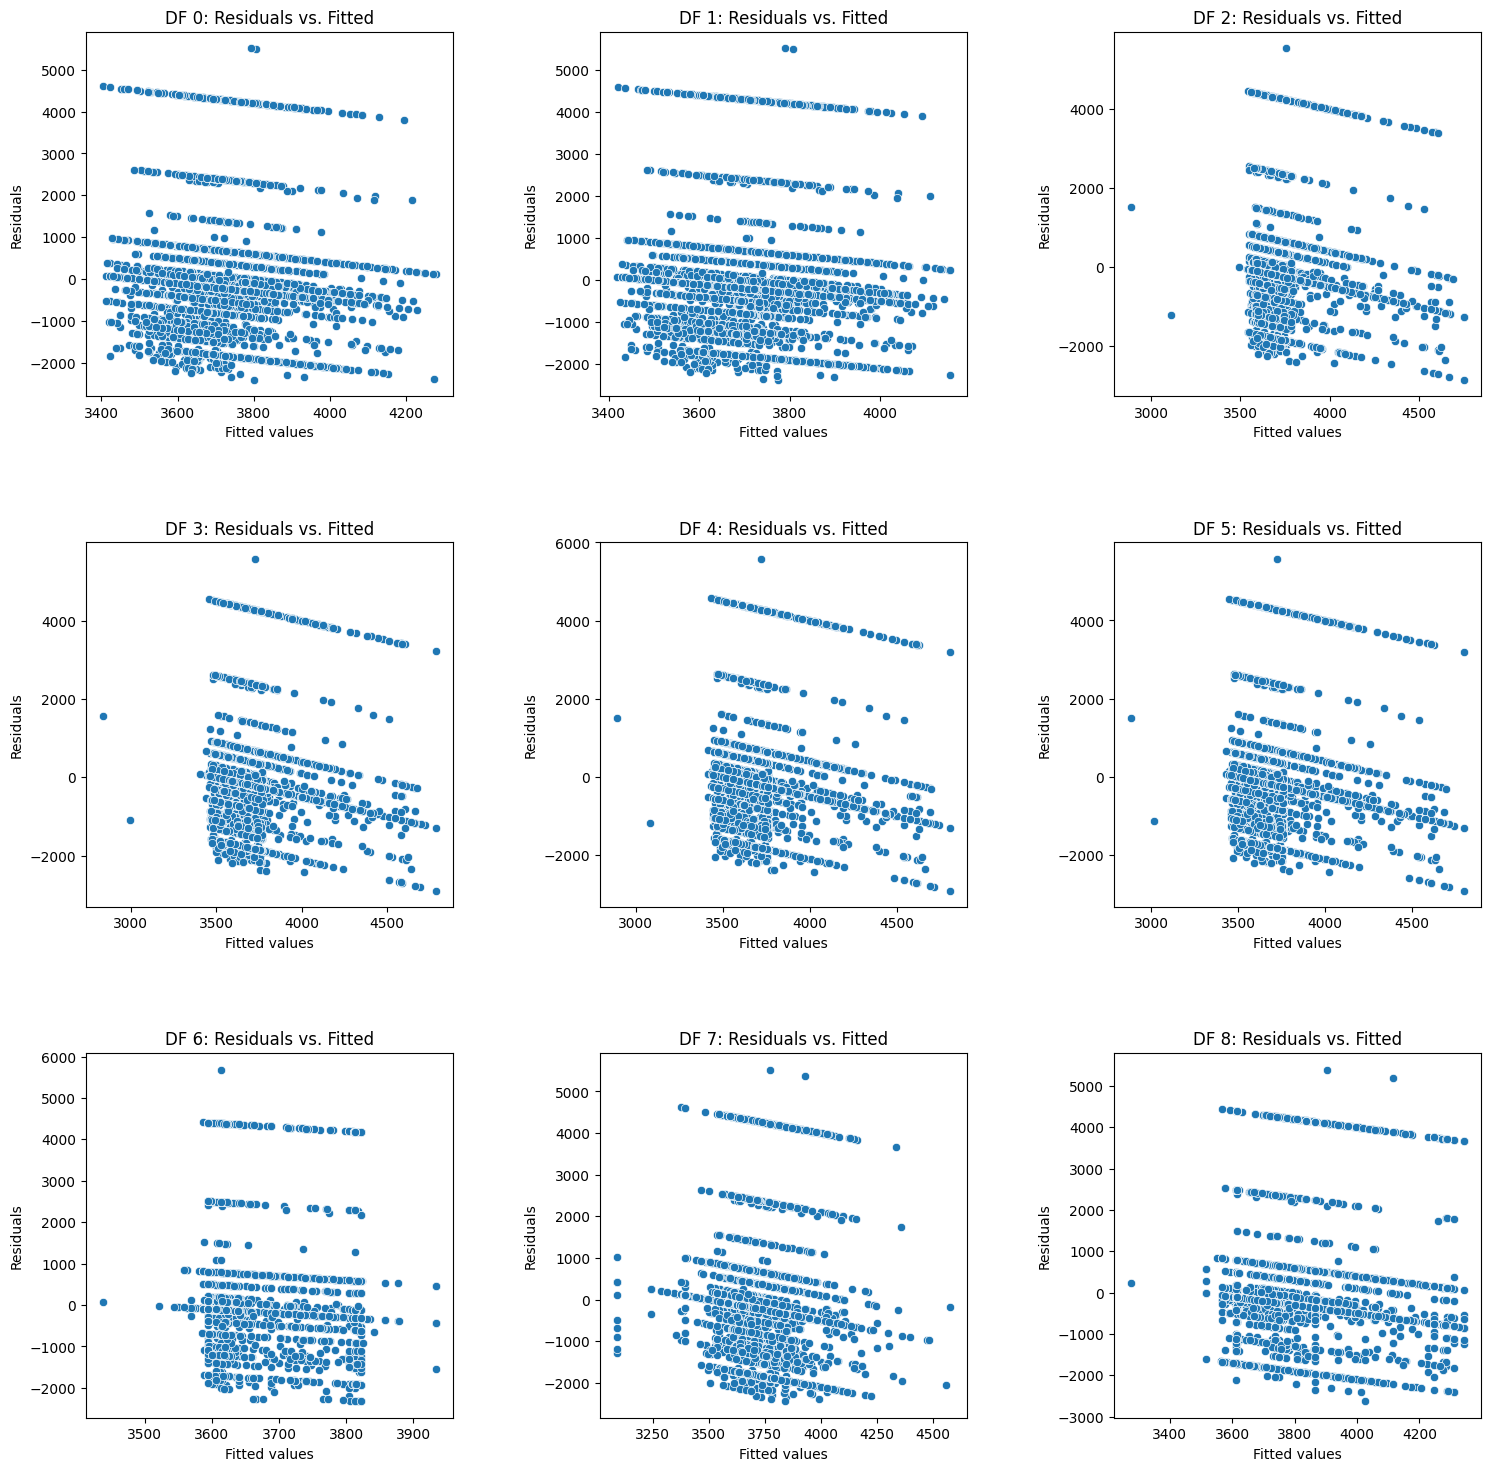

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Assuming dfs is a list of dataframes
n_rows, n_cols = 3, 3  # Define the layout of the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 18))  # Create a figure and a grid of subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

for i, df in enumerate(dfs):
    row, col = divmod(i, n_cols)
    
    # Define dependent and independent variables
    X = df[predictors]
    X = sm.add_constant(X)  # Adding the intercept term
    y = df[outcome]

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate predictions and residuals
    predictions = results.predict(X)
    residuals = y - predictions

    # Plot on the appropriate subplot
    ax = axs[row, col]
    sns.scatterplot(x=predictions, y=residuals, ax=ax)
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'DF {i}: Residuals vs. Fitted')

plt.show()

The White test

In [31]:
#Importing Libraries
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

# The outcome variable
y = 'Salaire_moyen_en_EQTP'

# The predictor variables
x = ['0', '1', '2']

# Loop over dataframes in dfs
for i, df in enumerate(dfs):
    # Fit the model
    model = sm.OLS(df[y], sm.add_constant(df[x])).fit()

    # Perform White's test
    white_test = het_white(model.resid, model.model.exog)

    # Print the results
    print(f"White's test results for dataframe {i+1}:")
    print(lzip(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], white_test))
    print()

White's test results for dataframe 1:
[('Lagrange multiplier statistic', 142.93562167362577), ('p-value', 2.553609841082635e-26), ('f-value', 16.064764491489726), ('f p-value', 1.7434778558584647e-26)]

White's test results for dataframe 2:
[('Lagrange multiplier statistic', 169.33524315303688), ('p-value', 8.487802103583439e-32), ('f-value', 19.07554007226157), ('f p-value', 4.901443820100754e-32)]

White's test results for dataframe 3:
[('Lagrange multiplier statistic', 86.53705872570015), ('p-value', 8.042584577684568e-15), ('f-value', 9.682921690859548), ('f p-value', 7.030667185721706e-15)]

White's test results for dataframe 4:
[('Lagrange multiplier statistic', 98.69427810324798), ('p-value', 2.889623766193296e-17), ('f-value', 11.057941323280616), ('f p-value', 2.400593494573087e-17)]

White's test results for dataframe 5:
[('Lagrange multiplier statistic', 107.08604618463896), ('p-value', 5.756433823896669e-19), ('f-value', 12.008320498559307), ('f p-value', 4.603397995825392e

The White Test has the null hypothesis that the errors are have same variance or homoscedastic. Having a p-value ≤ 0.05 would indicate that the null hypothesis is rejected, hence Heteroscedasticity

Here, only model 7 meets the assumption with p being greater than .05.


Solutions to lack of homoscedasticity:

- Outlier removal
- Log transformation of x variables
- Polynomial regresion


Alternatively - drop OLS and instead use:
- Weighted Least Squares (WLS) 
- Generalized Least Squares (GLS) 

### 3) Errors are normally distributed (Violated)

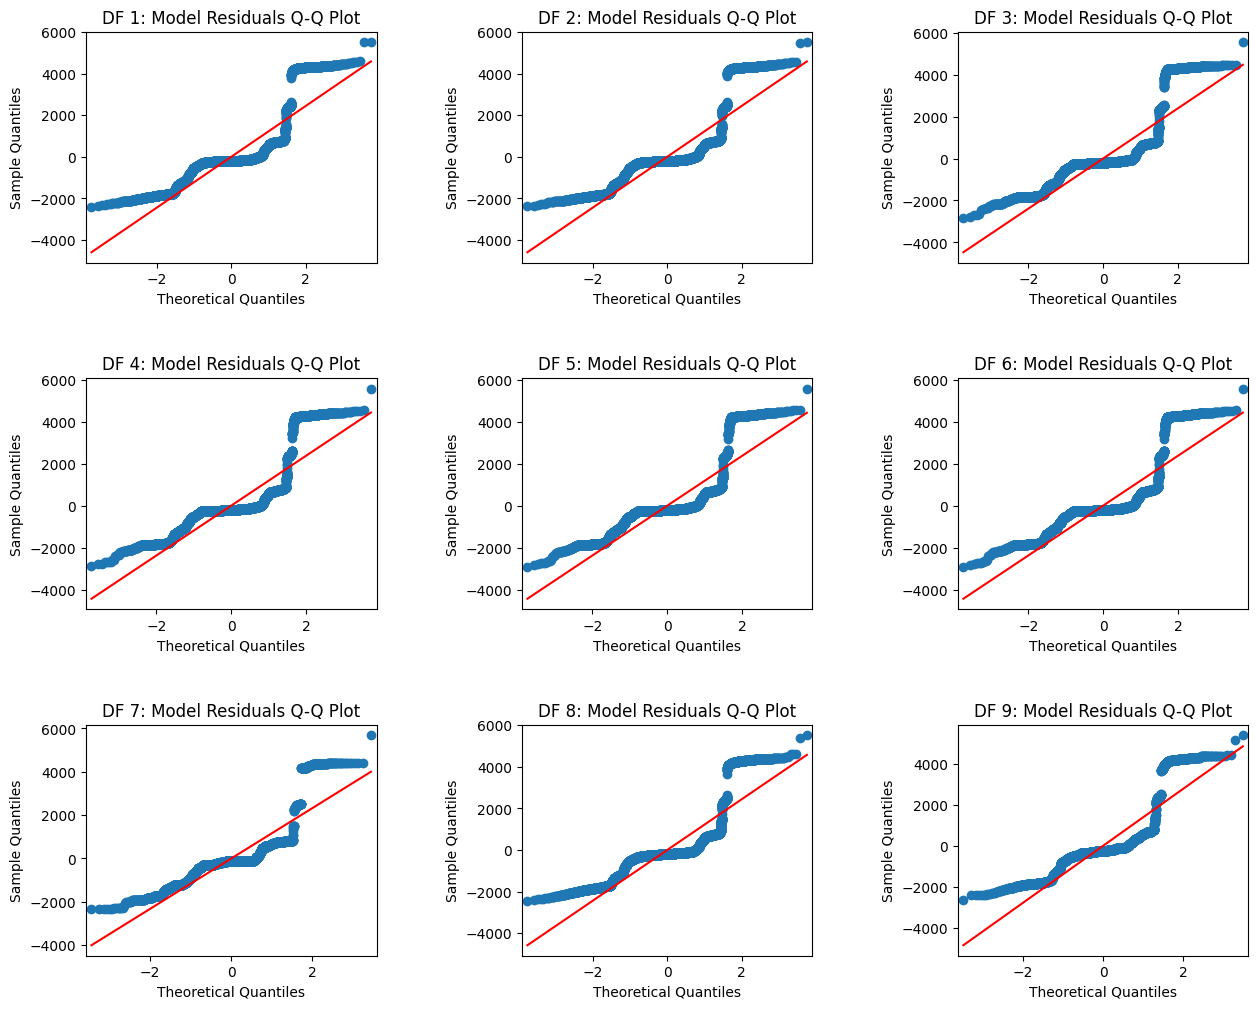

In [32]:
# Import necessary libraries
import matplotlib.pyplot as plt
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust space between plots

# Assuming dfs is a list of dataframes
for i, df in enumerate(dfs):
    row, col = divmod(i, 3)
    
    # Fit a linear regression model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Create QQ plot on the appropriate subplot
    ax = axs[row, col]
    sm.qqplot(results.resid, line='s', ax=ax)
    ax.set_title(f'DF {i+1}: Model Residuals Q-Q Plot')

# Hide any unused subplots if dfs has less than 9 elements
for j in range(i+1, 9):
    fig.delaxes(axs.flatten()[j])

plt.show()

### 4) Independent observations - no autocorrelatiions ***

Yes, because:
Being a factor analysis method spatialisation assures non linear dependence between spatialisation along CA dimensions. At least for the first N. That’s another why I think taking N=3 is a good bet.

### 5) No multicolinearity - Predictors are not correlated with each other ***

Below: Across all models, the predictors are not highly correlated.

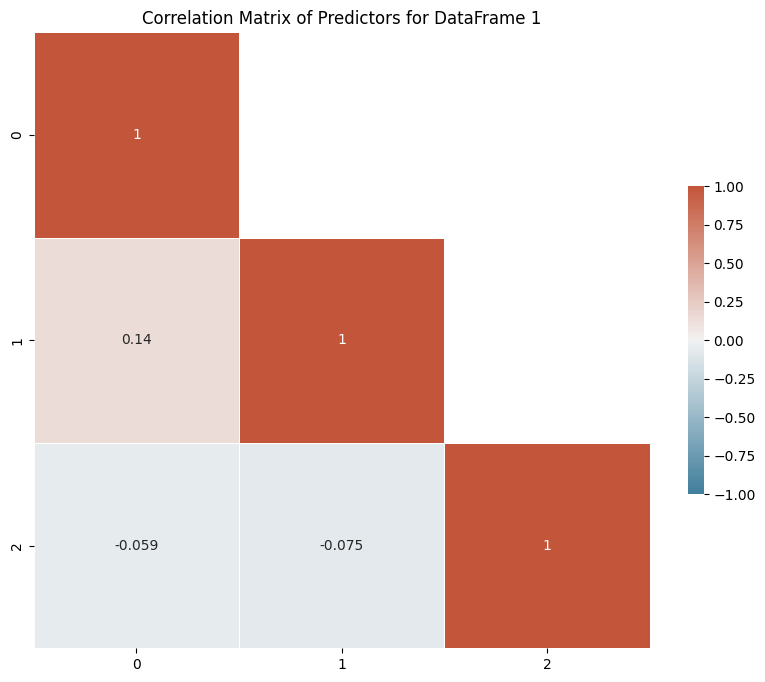

   VIF Factor features
0    1.051850        0
1    1.051903        1
2    1.000238        2
Model 1 does not have high multicollinearity


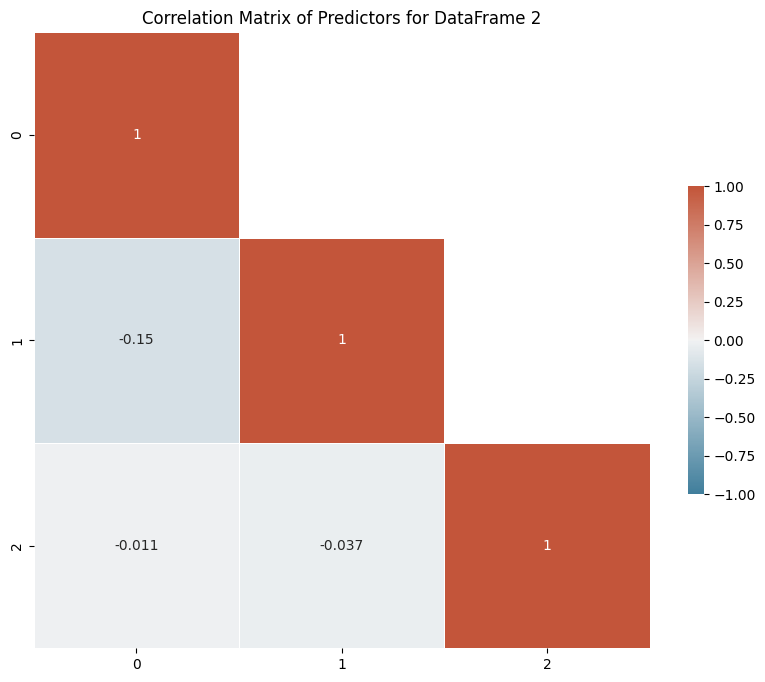

   VIF Factor features
0    1.077681        0
1    1.067753        1
2    1.032557        2
Model 2 does not have high multicollinearity


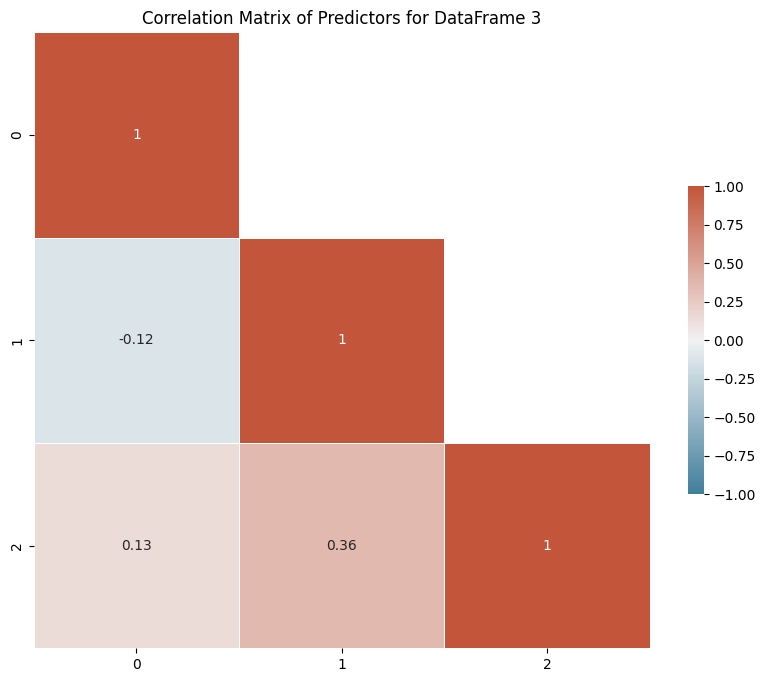

   VIF Factor features
0    1.156443        0
1    1.213515        1
2    1.198152        2
Model 3 does not have high multicollinearity


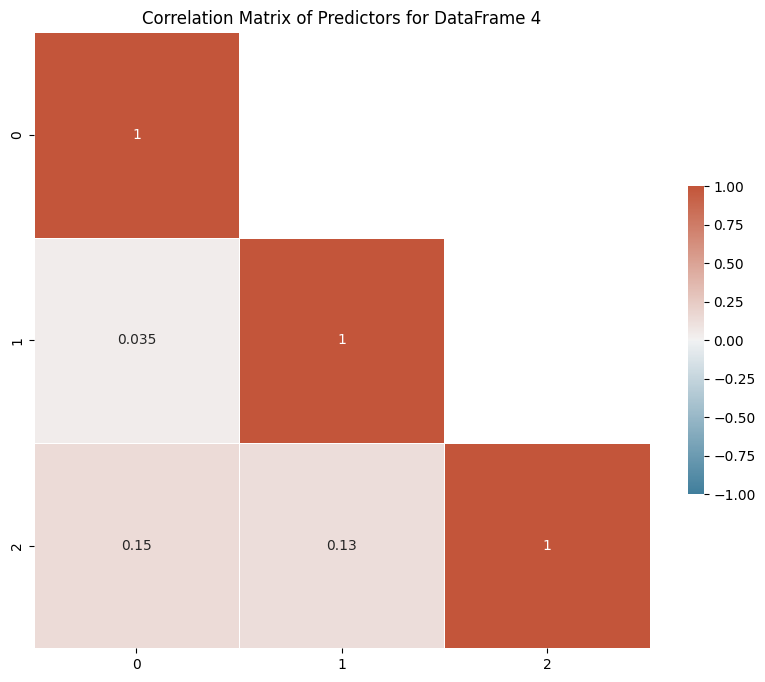

   VIF Factor features
0    1.158977        0
1    1.008447        1
2    1.162653        2
Model 4 does not have high multicollinearity


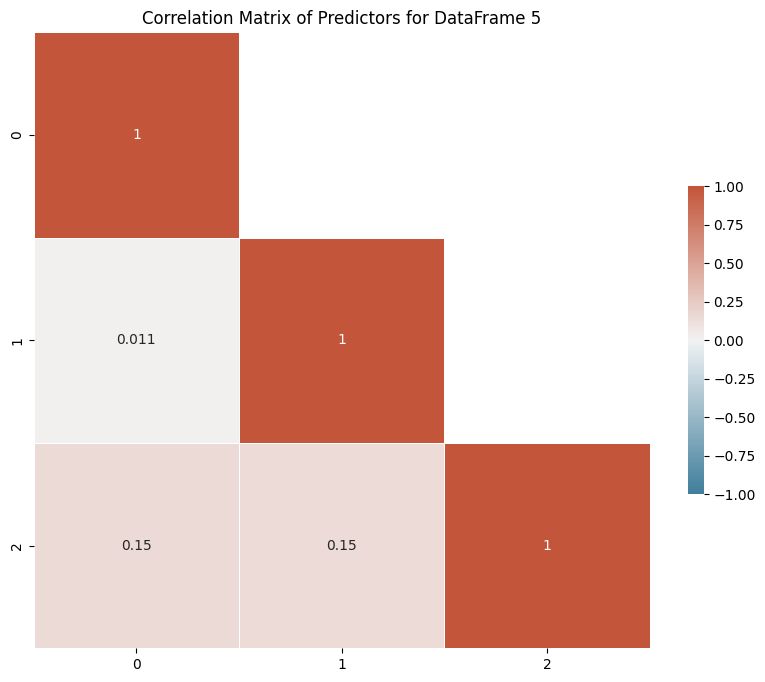

   VIF Factor features
0    1.186866        0
1    1.015264        1
2    1.182868        2
Model 5 does not have high multicollinearity


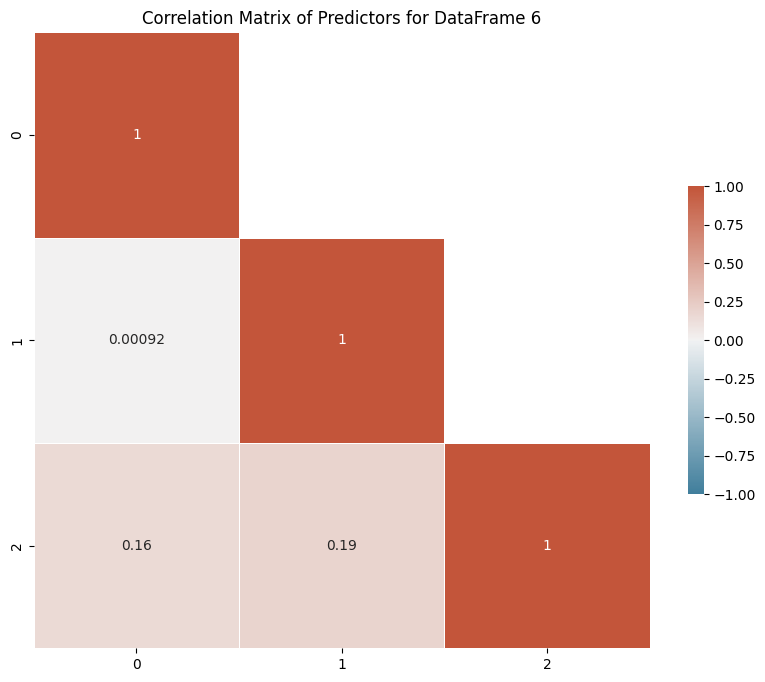

   VIF Factor features
0    1.197252        0
1    1.030261        1
2    1.189551        2
Model 6 does not have high multicollinearity


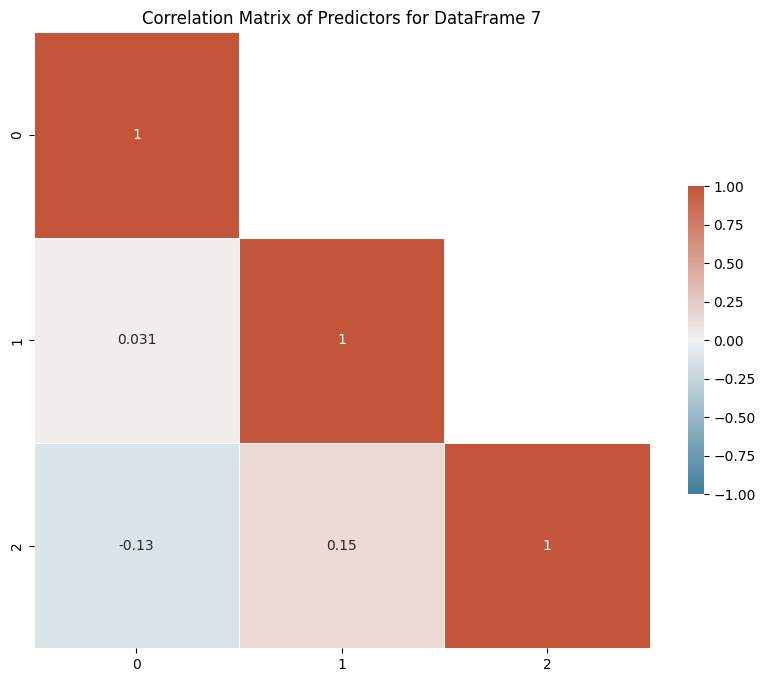

   VIF Factor features
0    1.013245        0
1    1.026275        1
2    1.036007        2
Model 7 does not have high multicollinearity


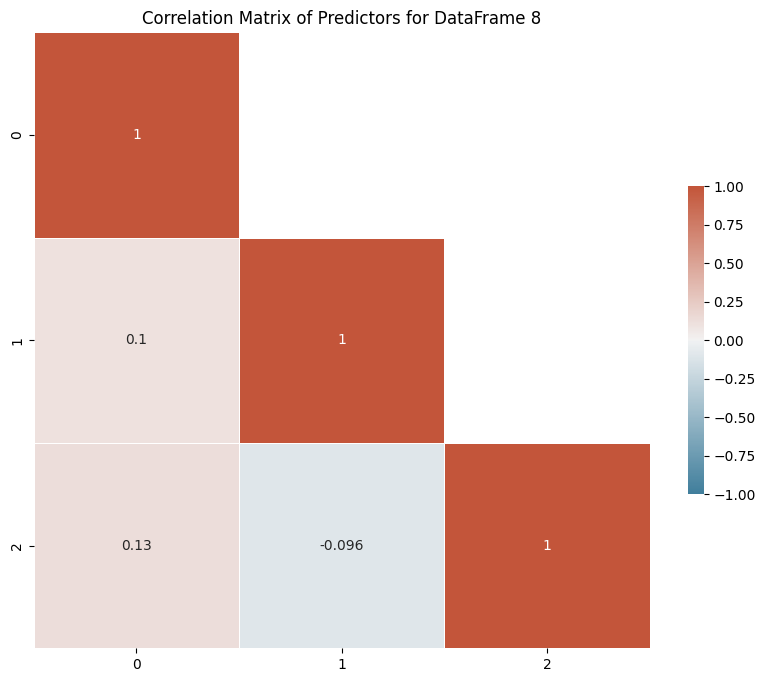

   VIF Factor features
0    1.039742        0
1    1.023754        1
2    1.046311        2
Model 8 does not have high multicollinearity


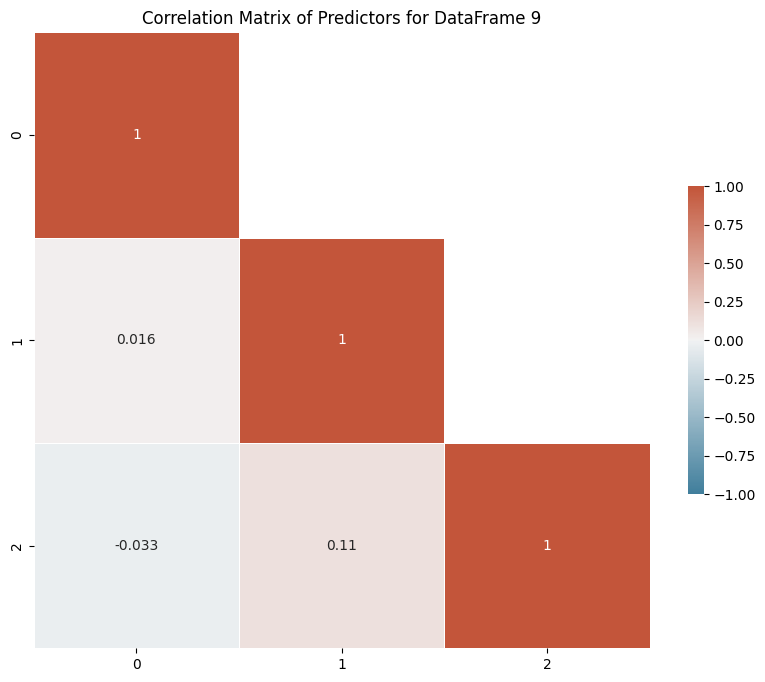

   VIF Factor features
0    1.001291        0
1    1.013552        1
2    1.014629        2
Model 9 does not have high multicollinearity


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Loop over dataframes in dfs
for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    corr_matrix = df[predictors].corr()

    # Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
    # top-left to bottom-right diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # k=1 keeps the main diagonal unmasked

    # Create a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1,  # Set color range from -1 to 1
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    plt.title(f'Correlation Matrix of Predictors for DataFrame {i+1}')
    plt.show()

    # Calculate VIF for each predictor
    X = df[predictors]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, j) for j in range(X.shape[1])]
    vif["features"] = X.columns

    print(vif)

    # Check if there's high multicollinearity
    if vif["VIF Factor"].max() > 5:
        print(f'Model {i+1} might have high multicollinearity')
    else:
        print(f'Model {i+1} does not have high multicollinearity')

Here, I am just checking correlations between aggregated coordinate values per job title, and the income. Also checking the correlation between occupational class and income.

### 7) Independence of residuals *** no significant autocorrelation

In [6]:
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

for i, df in enumerate(dfs):
    # Fit a linear regression model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate residuals
    residuals = y - results.predict(X)

    # Apply Durbin-Watson test
    dw = durbin_watson(residuals)

    print(f'Durbin-Watson statistic for dataframe {i}: {dw}')

Durbin-Watson statistic for dataframe 0: 1.9903018029976685
Durbin-Watson statistic for dataframe 1: 1.9898706651528912
Durbin-Watson statistic for dataframe 2: 1.9922987206689473
Durbin-Watson statistic for dataframe 3: 1.9957051436355844
Durbin-Watson statistic for dataframe 4: 1.9939558264687494
Durbin-Watson statistic for dataframe 5: 1.994691965525289
Durbin-Watson statistic for dataframe 6: 2.015929925478694
Durbin-Watson statistic for dataframe 7: 1.9895332703747142
Durbin-Watson statistic for dataframe 8: 2.0508776094400596


In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

Weighted least squares (WLS), also known as weighted linear regression,is a generalization of ordinary least squares and linear regression in which knowledge of the unequal variance of observations (heteroscedasticity) is incorporated into the regression. 

In a weighted fit, less weight is given to the
less precise measurements and more weight
to more precise measurements when
estimating the unknown parameters in the
model.
Using weights that are inversely proportional
to the variance at each level of the explanatory
variables yields the most precise parameter
estimates possible.

In [40]:
# Loop over all dataframes
for i, df in enumerate(dfs):
    # Calculate the mean values for each group
    grouped_means = df.groupby('PCS_ESE')[predictors + [outcome]].mean()
    
    # Calculate the correlation matrix
    correlation_matrix = grouped_means.corr()
    
    # Print the correlation matrix for each dataframe
    print(f"Correlation matrix for dataframe {i}:")
    print(correlation_matrix)
    print("\n")

Correlation matrix for dataframe 0:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.164887  0.376979              -0.350158
1                     -0.164887  1.000000 -0.208947               0.276866
2                      0.376979 -0.208947  1.000000              -0.188425
Salaire_moyen_en_EQTP -0.350158  0.276866 -0.188425               1.000000


Correlation matrix for dataframe 1:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000  0.216007 -0.448156               0.357874
1                      0.216007  1.000000 -0.282602               0.296153
2                     -0.448156 -0.282602  1.000000              -0.144116
Salaire_moyen_en_EQTP  0.357874  0.296153 -0.144116               1.000000


Correlation matrix for dataframe 2:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.345016  0.441525            

## 3 Model Fitting and Comparison

Here, I am fitting multidimensional OLS to do model selection. 
The model that gives the best fit will be selected for durther inspection. 

In [4]:
# Loading CA job coord files
importlib.reload(utils2)

# Load the coordinate files for models 1 to 9
dfs = utils2.load_CA_model_files(9)

for i, df in enumerate(dfs):
    print(f"Shape of dataframe {i+1}: {df.shape}")

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of dataframe 7: 

In [71]:
#SD per model of interest
# Calculate the standard deviation of the outcome variable for each model
outcome = 'Salaire_moyen_en_EQTP'

dfs1 = [dfs[0], dfs[2], dfs[6]]
std_devs = [df[outcome].std() for df in dfs1]

# Print the standard deviations
model_numbers = [1, 3, 7]
for i, std_dev in enumerate(std_devs):
    print(f"Standard deviation of outcome for model {model_numbers[i]}: {std_dev}")

Standard deviation of outcome for model 1: 1223.4328200874204
Standard deviation of outcome for model 3: 1198.9050597542246
Standard deviation of outcome for model 7: 1163.5893172071164


Below, I am performing a k-fold cross validation on a set of dfs using OLS and WLS regression. 
I identify the model with the lowes Root Mean Squared error. 


In [96]:
outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Create an instance of the class with required arguments
model_comp = CrossValidation(dfs, predictors, outcome)

# Call the fit method
model_comp.fit()
model_comp.print_summaries()


     DataFrame  Mean RMSE (CV)   R2 (CV)  R2 (Full) Max Coeff Predictor  \
0  DataFrame 1     1438.970726  0.877553   0.997989                   0   
1  DataFrame 2     1451.391885  0.880866   0.993184                   0   
2  DataFrame 3     1409.298829  0.710566   0.866417                   0   
3  DataFrame 4     1433.001837  0.898672   0.986411                   0   
4  DataFrame 5     1425.372351  0.878926   0.918758                   0   
5  DataFrame 6     1426.434008  0.918591   0.957900                   0   
6  DataFrame 7     1316.693404  0.468981   0.278562                   0   
7  DataFrame 8     1420.011838  0.933102   0.975443                   2   
8  DataFrame 9     1435.581480  0.853042   0.782817                   1   

   Max Coeff Value            AIC            BIC  
0      -153.529663  169107.235575  169136.697423  
1       154.898849  169205.957232  169235.418738  
2       145.571757  159019.949329  159049.156629  
3       177.554142  154718.746161  154747.851

In [73]:
#Calculate the Spearman correlation between predictors and outcome, and return the dimension with the highest correlation 
model_comp.calculate_correlations_median('PCS_ESE')

     DataFrame Predictor  Correlation   P-value
0  DataFrame 1         0    -0.357339  0.006858
1  DataFrame 2         0     0.344167  0.009396
2  DataFrame 3         0     0.231251  0.086378
3  DataFrame 4         0     0.202888  0.133699
4  DataFrame 5         0     0.172646  0.203229
5  DataFrame 6         0     0.215925  0.109975
6  DataFrame 7         1     0.199149  0.148823
7  DataFrame 8         0    -0.218166  0.106244
8  DataFrame 9         0    -0.067230  0.639250


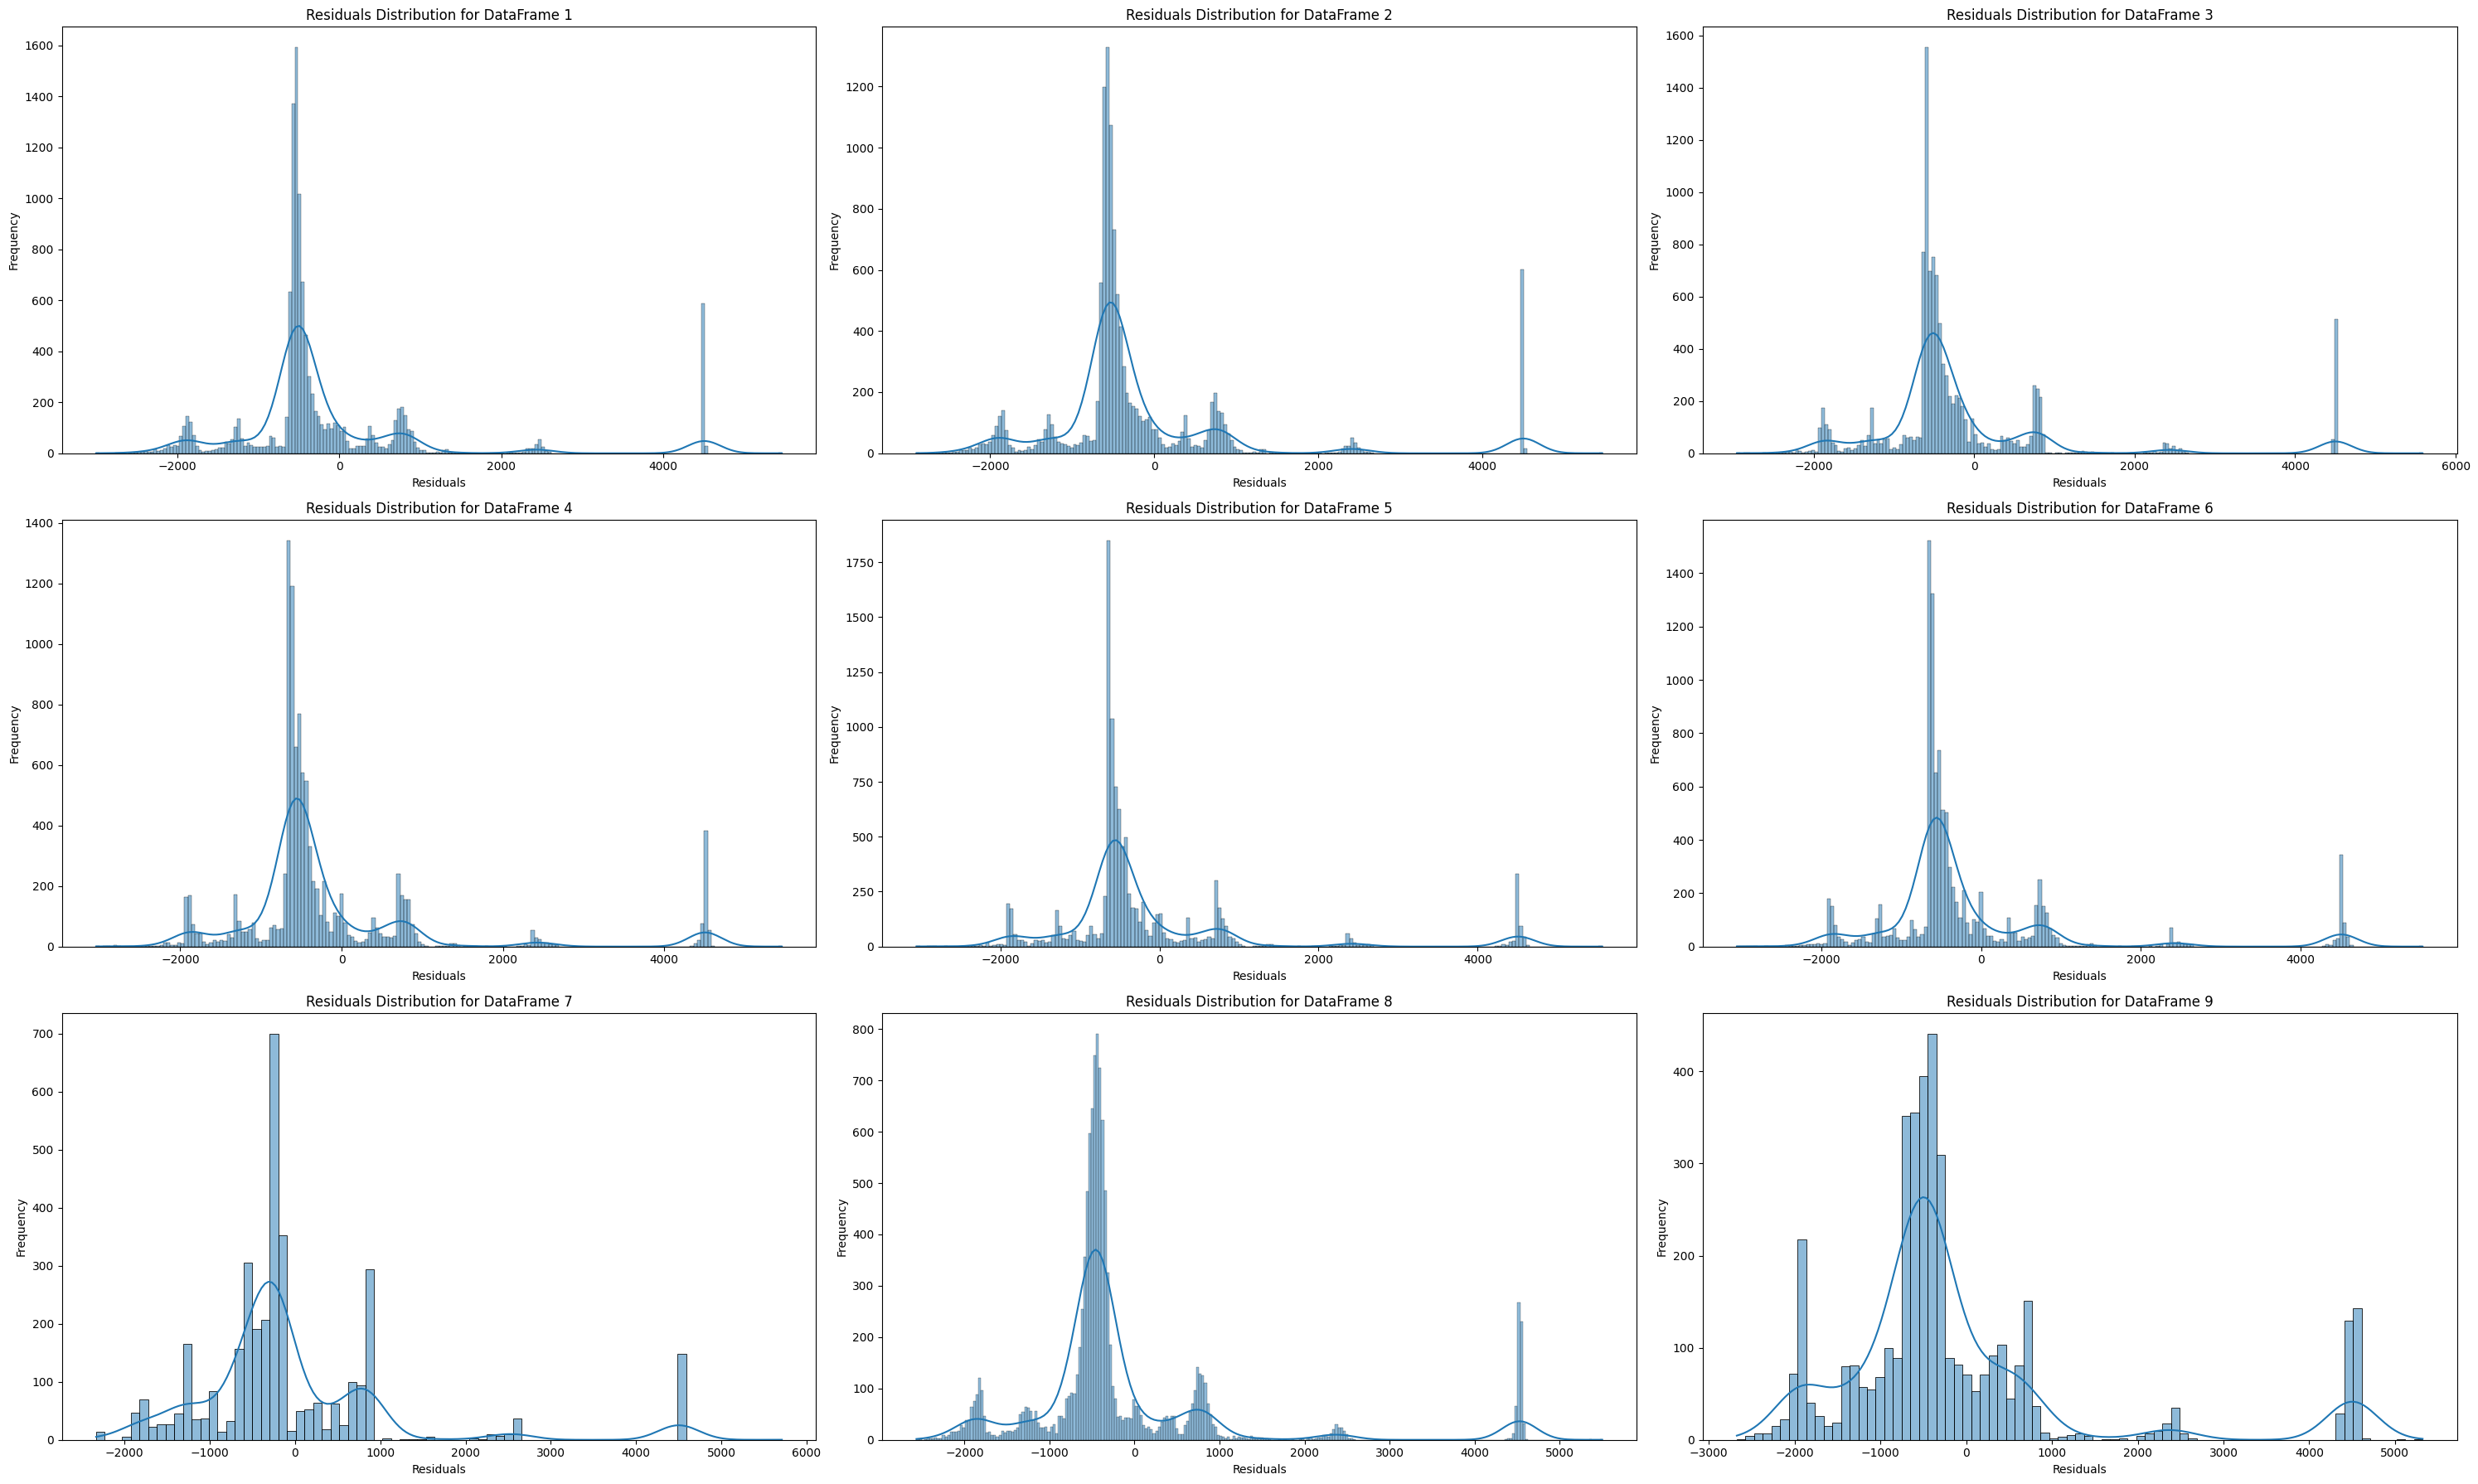

In [88]:
model_comp.plot_residuals()